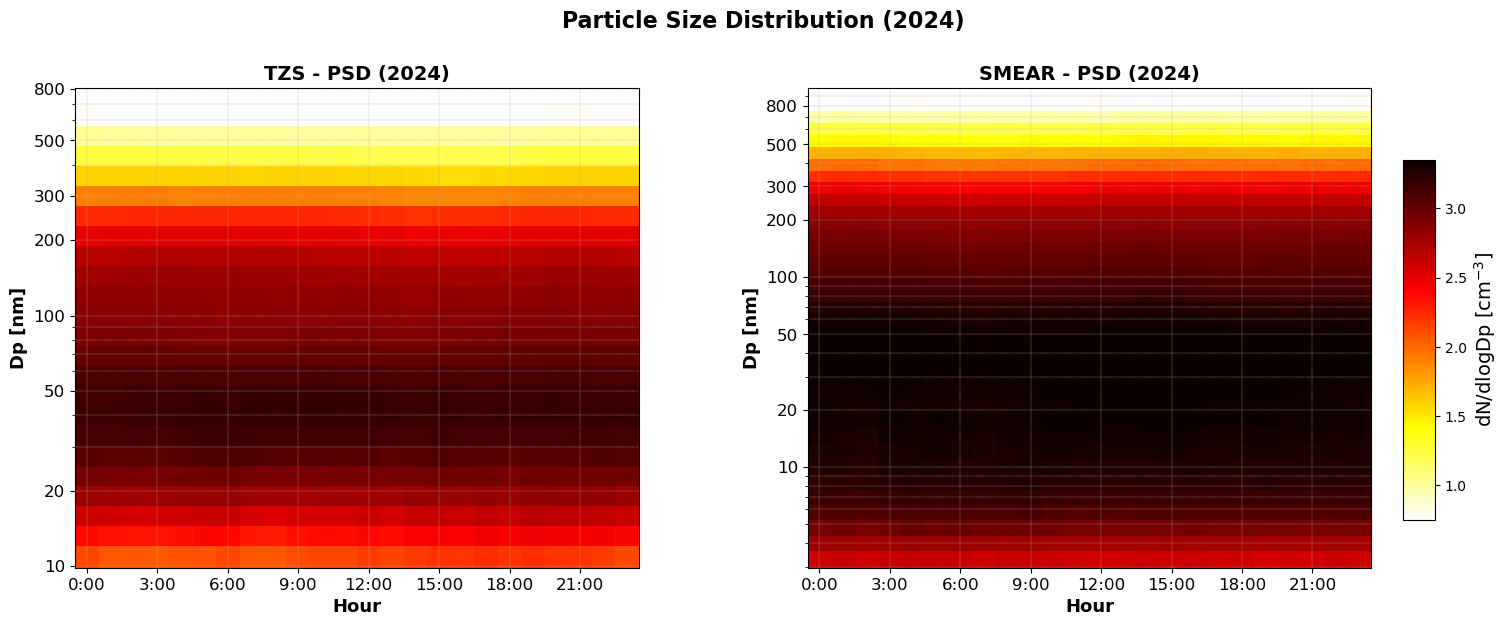

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === Load Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_data = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Function to process and extract PSD data with log10 dN/dlogDp ===
def process_psd_data(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]  # Drop first bin edge
    trimmed = trimmed.replace(0, np.nan)
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints_nm
    return log_data, bin_midpoints_nm

tzs_log, tzs_bins = process_psd_data(tzs_data)
smear_log, smear_bins = process_psd_data(smear_data)

# === Function to calculate diurnal average ===
def calculate_diurnal_average(log_data):
    hourly_avg = log_data.groupby(log_data.index.time).mean()
    time_index = pd.date_range("00:00", "23:00", freq="H").time
    hourly_avg = hourly_avg.reindex(time_index)
    return hourly_avg.T  # Transpose for heatmap

# Compute diurnal averages
tzs_diurnal = calculate_diurnal_average(tzs_log)
smear_diurnal = calculate_diurnal_average(smear_log)

# === Tick helper ===
def valid_ticks_from_bins(bins, custom_ticks):
    return sorted(set([custom_ticks[0], custom_ticks[-1]] + [t for t in custom_ticks if bins.min() <= t <= bins.max()]))

# === Tick values ===
tzs_ticks = valid_ticks_from_bins(tzs_bins, [10, 20, 50, 100, 200, 300, 500, 800])
smear_ticks = valid_ticks_from_bins(smear_bins, [10, 20, 50, 100, 200, 300, 500, 800])

# === Determine global color scale ===
combined_values = np.concatenate([
    tzs_diurnal.values.flatten(),
    smear_diurnal.values.flatten()
])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
cmap = plt.cm.get_cmap('hot_r')
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for ax, data, bins, label, ticks in [
    (axes[0], tzs_diurnal, tzs_bins, 'TZS', tzs_ticks),
    (axes[1], smear_diurnal, smear_bins, 'SMEAR', smear_ticks)
]:
    X, Y = np.meshgrid(range(24), bins)
    c = ax.pcolormesh(X, Y, data, cmap=cmap, norm=norm, shading='auto')
    ax.set_yscale('log')
    ax.set_xticks(range(0, 24, 3))
    ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 3)], fontsize=12)
    ax.set_yticks(ticks)
    ax.set_yticklabels([str(t) for t in ticks], fontsize=12)
    ax.set_xlabel("Hour", fontsize=13, weight='bold')
    ax.set_ylabel("Dp [nm]", fontsize=13, weight='bold')
    ax.set_title(f"{label} - PSD (2024)", fontsize=14, weight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.3)

# === Colorbar and Layout ===
plt.subplots_adjust(left=0.07, right=0.88, top=0.92, bottom=0.12, wspace=0.3)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=14, weight='bold')

# === Main Title moved slightly higher ===
plt.suptitle("Particle Size Distribution (2024)", fontsize=16, weight='bold', y=1.05)

plt.show()

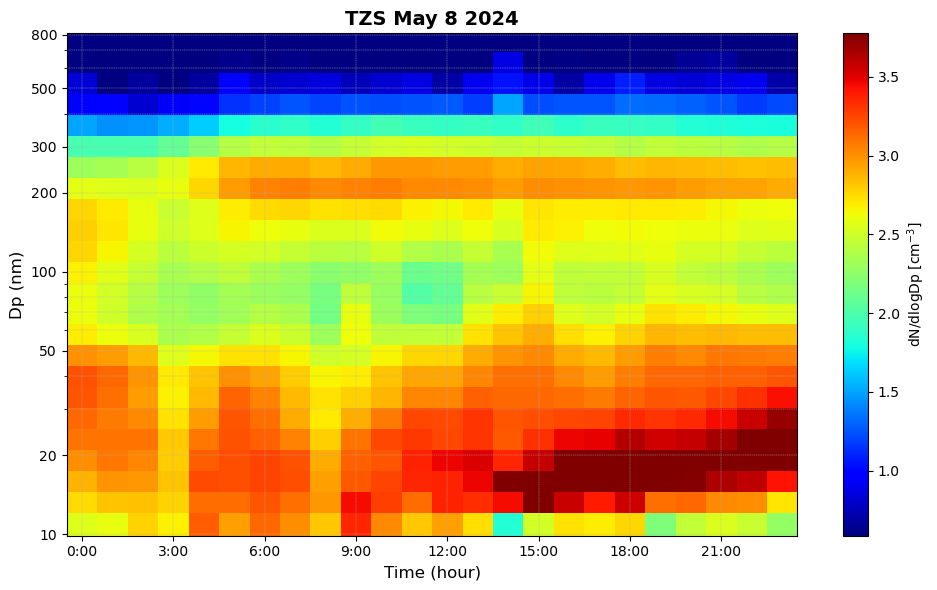

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Excel data
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)

# ---------------------------------------------------------------
# STEP 1: Extract bin edges and compute geometric midpoints (Dp)
# ---------------------------------------------------------------
bin_edges_m = tzs_data.columns.astype(float).to_numpy()           # in meters
bin_edges_nm = bin_edges_m * 1e9                                  # convert to nanometers
bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])  # geometric midpoints

# ---------------------------------------------------------------
# STEP 2: Prepare TZS data for May, remove 0s, and use midpoints
# ---------------------------------------------------------------
tzs_may = tzs_data[tzs_data.index.month == 5].replace(0, np.nan)
tzs_may.columns = bin_edges_nm                                    # assign bin edges temporarily
tzs_may_trimmed = tzs_may.iloc[:, 1:]                             # drop first edge column
tzs_log = np.log10(tzs_may_trimmed)                               # log-transform
tzs_log.columns = bin_midpoints_nm                                # use midpoints as column names

# ---------------------------------------------------------------
# STEP 3: Select a day (e.g., May 8) and compute hourly mean
# ---------------------------------------------------------------
day = 8
daily_data = tzs_log[tzs_log.index.day == day]
hourly_mean = daily_data.groupby(daily_data.index.time).mean()

# Ensure full 24-hour coverage
time_index = pd.date_range("00:00", "23:00", freq="H").time
hourly_mean = hourly_mean.reindex(time_index, fill_value=np.nan)

# ---------------------------------------------------------------
# STEP 4: Plotting using corrected size axis (Frans-style)
# ---------------------------------------------------------------
X, Y = np.meshgrid(range(24), bin_midpoints_nm)

# Set color scale range based on percentiles
vmin = np.nanpercentile(tzs_log.values, 5)
vmax = np.nanpercentile(tzs_log.values, 95)

# Define Frans-style Y-ticks (including 10 and 800 explicitly)
custom_ticks = [10, 20, 50, 100, 200, 300, 500, 800]
valid_ticks = sorted(set([10, 800] + [tick for tick in custom_ticks if bin_midpoints_nm.min() <= tick <= bin_midpoints_nm.max()]))

# Plot
plt.figure(figsize=(10, 6))
c = plt.pcolormesh(X, Y, hourly_mean.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
plt.yscale('log')
plt.colorbar(c, label=r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$')

plt.title("TZS May 8 2024", fontsize=14, fontweight='bold')
plt.xlabel("Time (hour)", fontsize=12)
plt.ylabel("Dp (nm)", fontsize=12)
plt.xticks(range(0, 24, 3), [f"{h}:00" for h in range(0, 24, 3)])
plt.yticks(valid_ticks, [str(t) for t in valid_ticks])
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

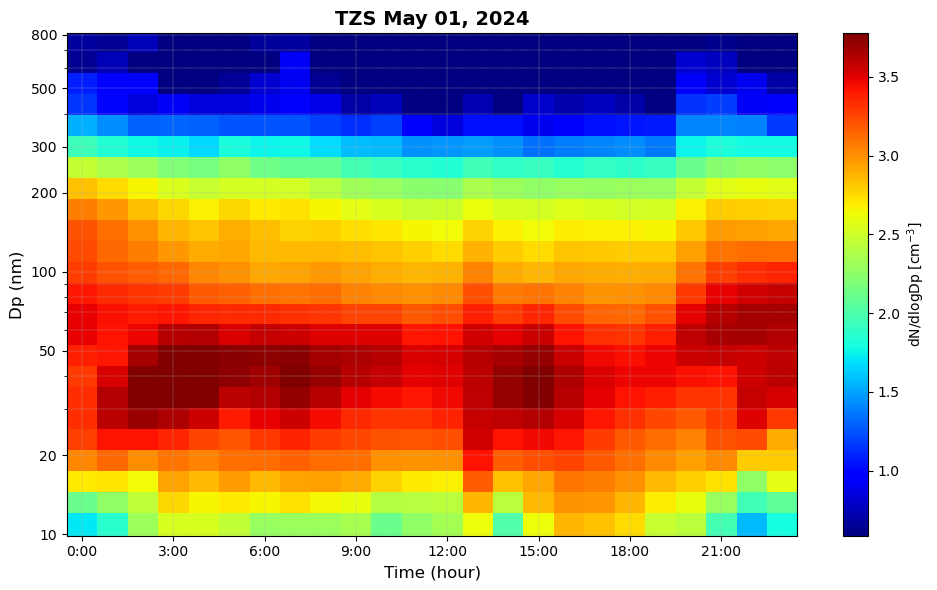

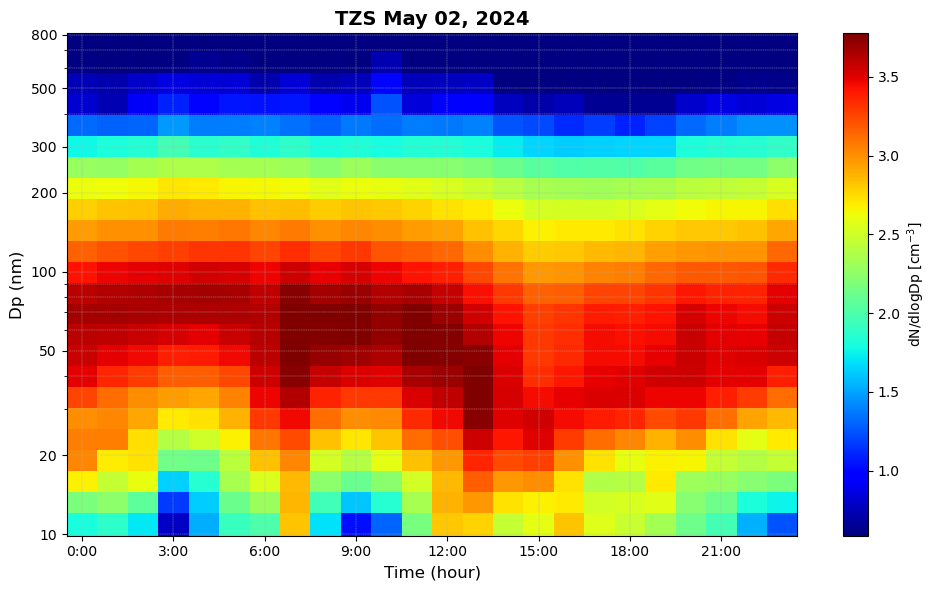

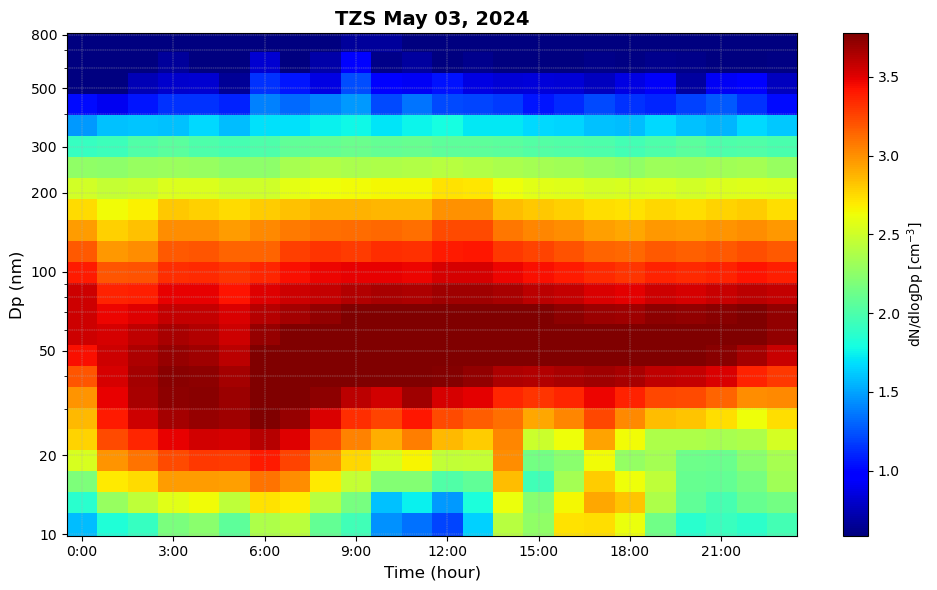

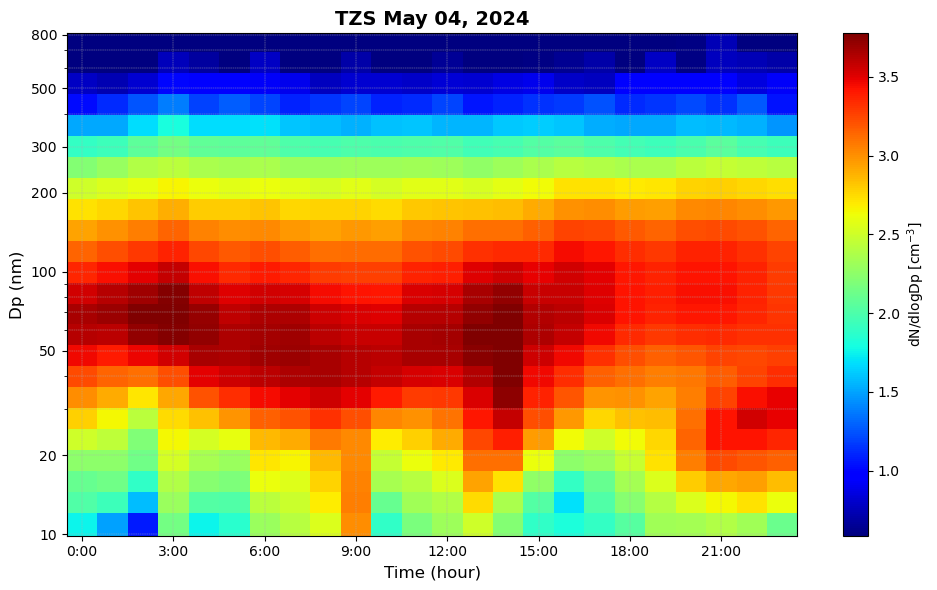

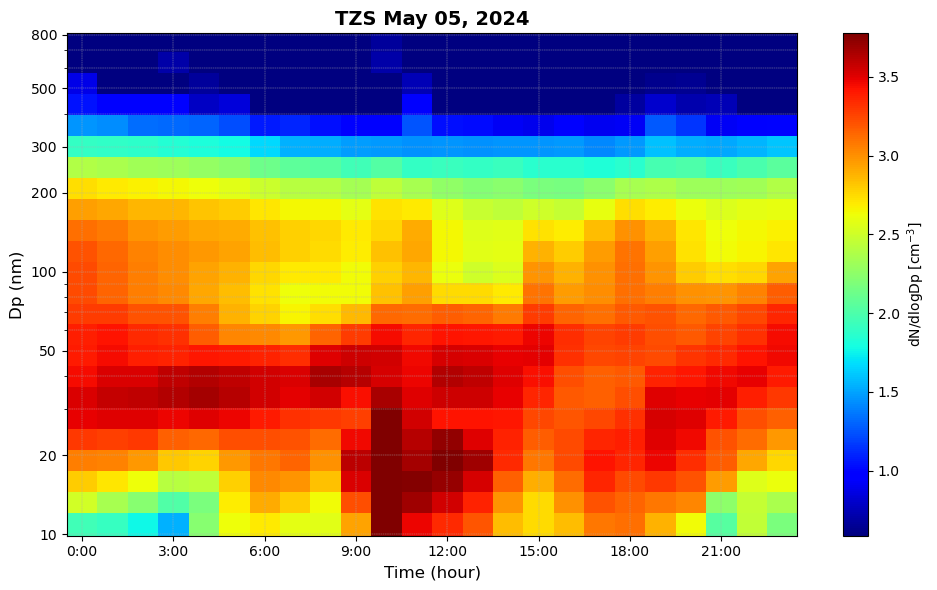

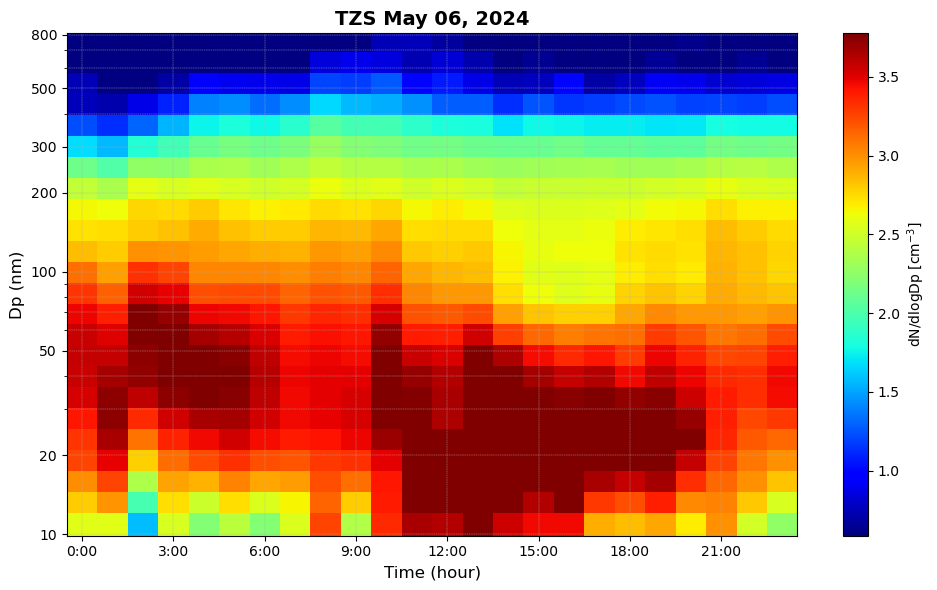

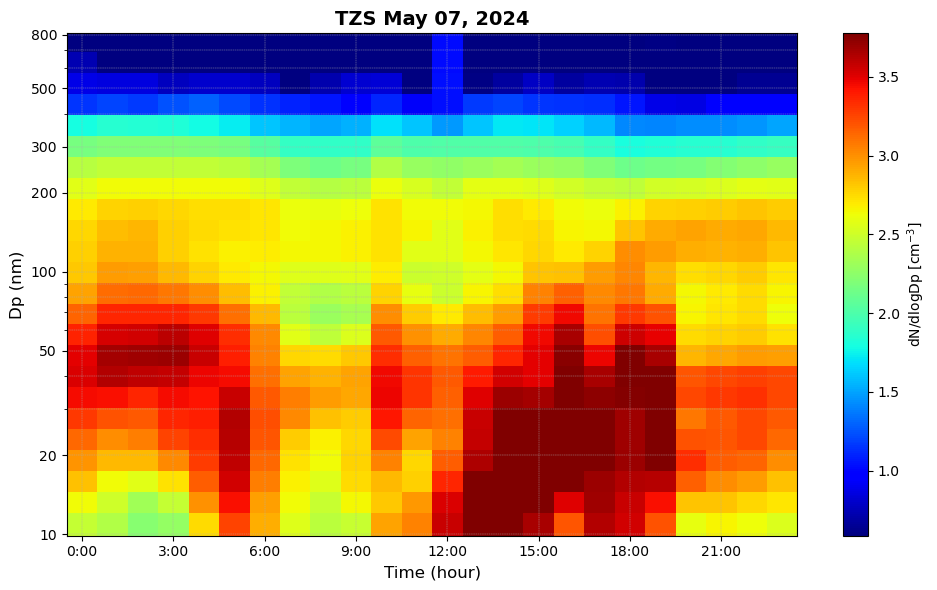

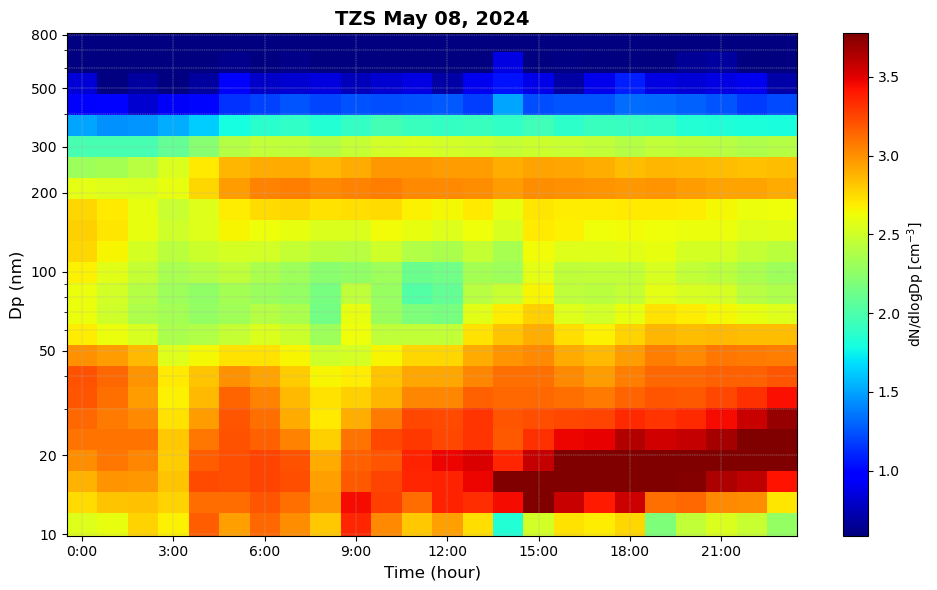

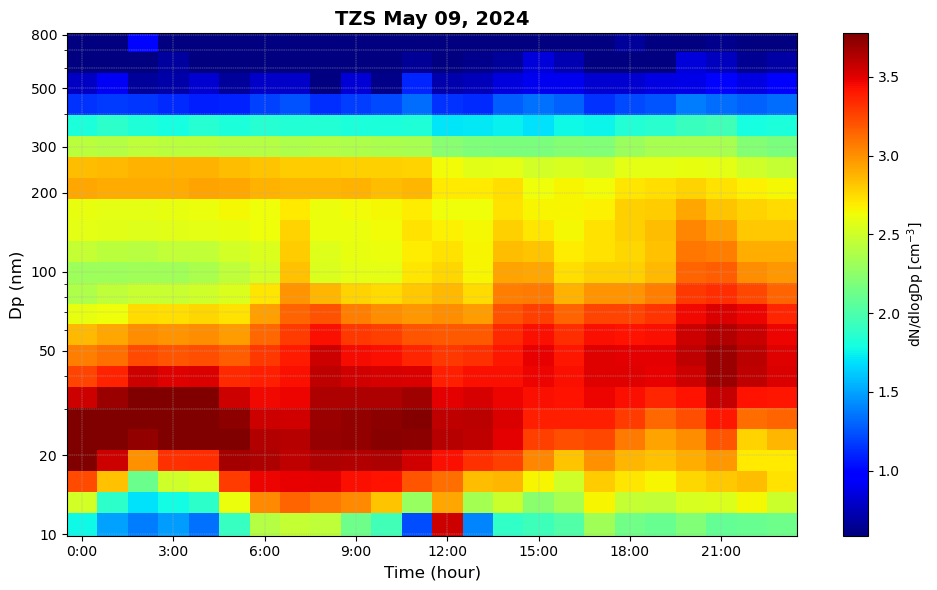

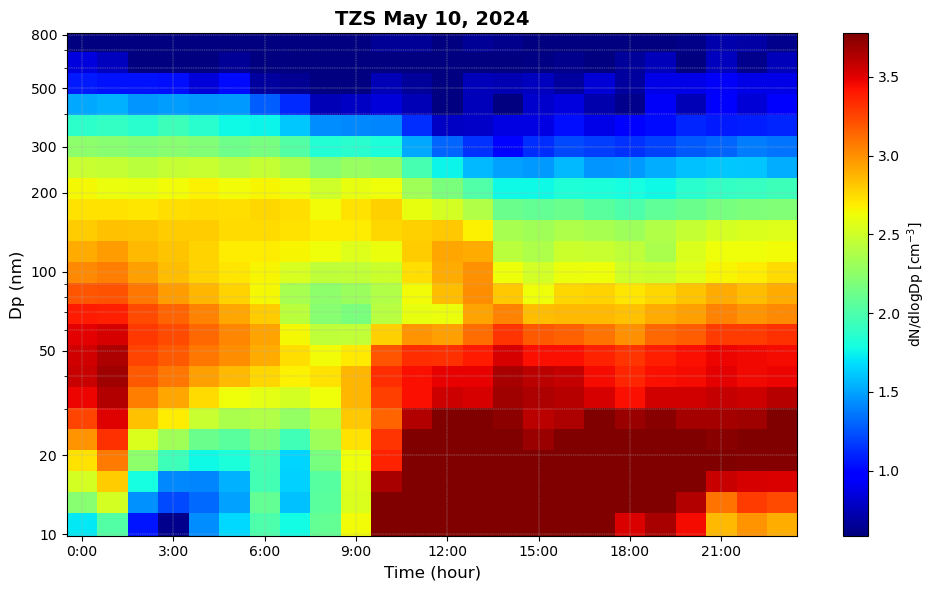

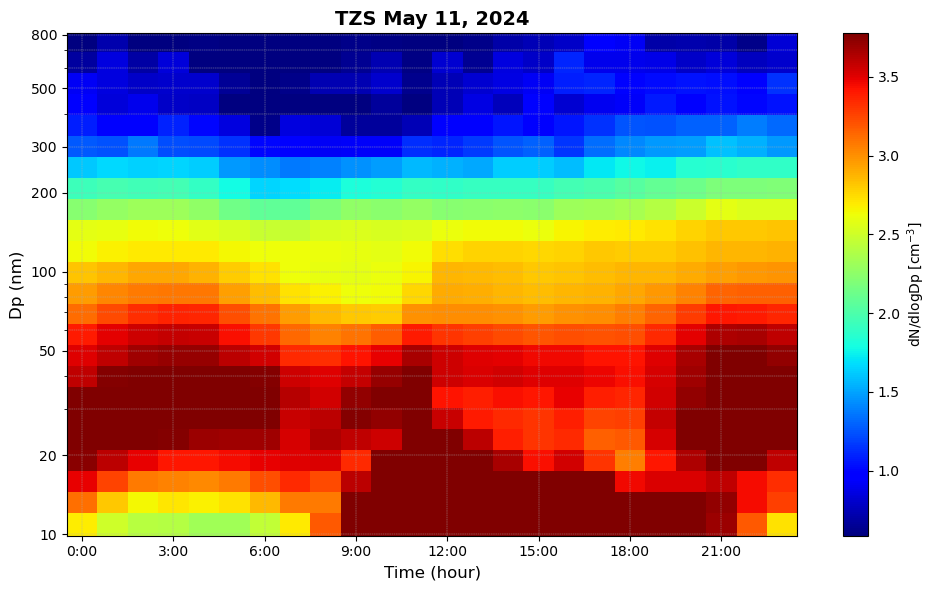

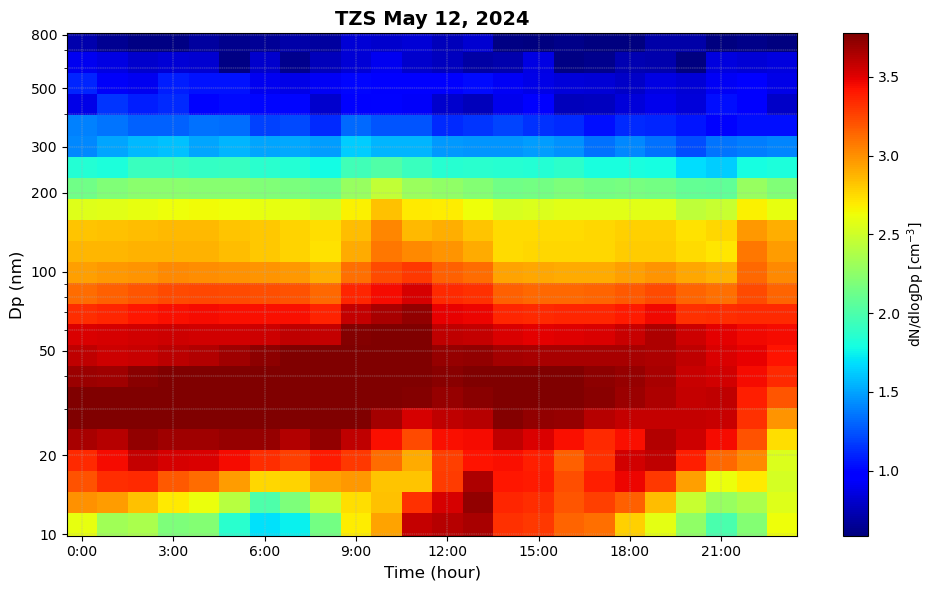

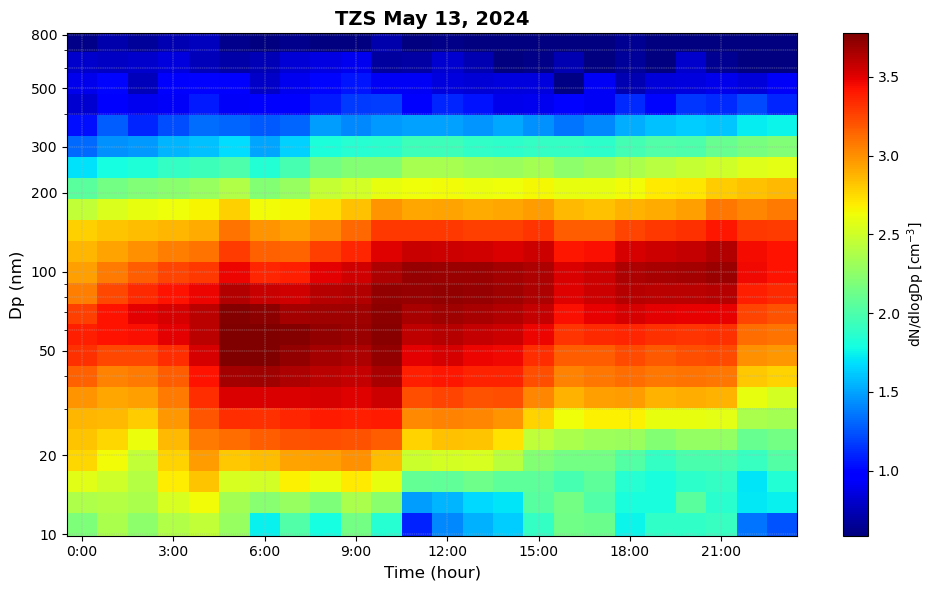

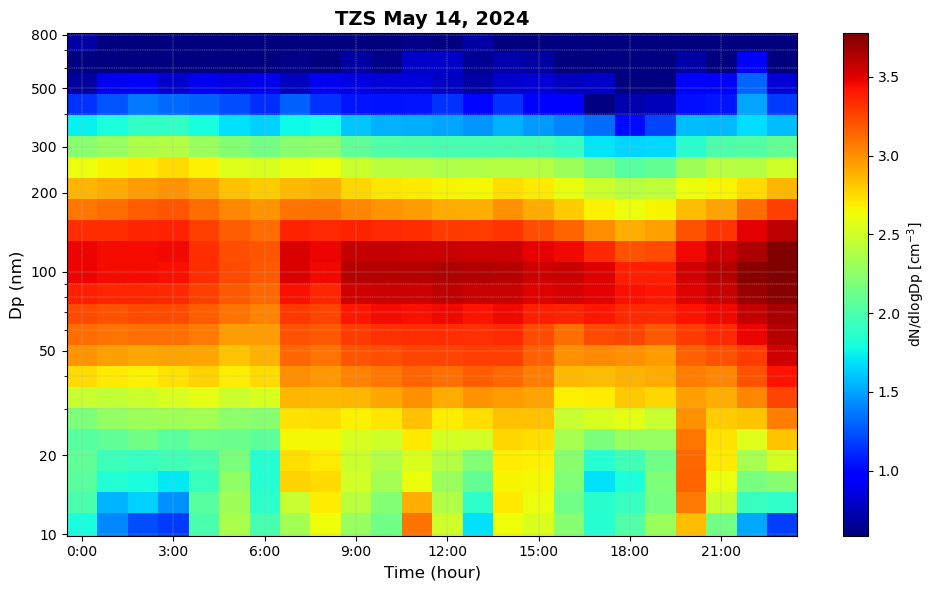

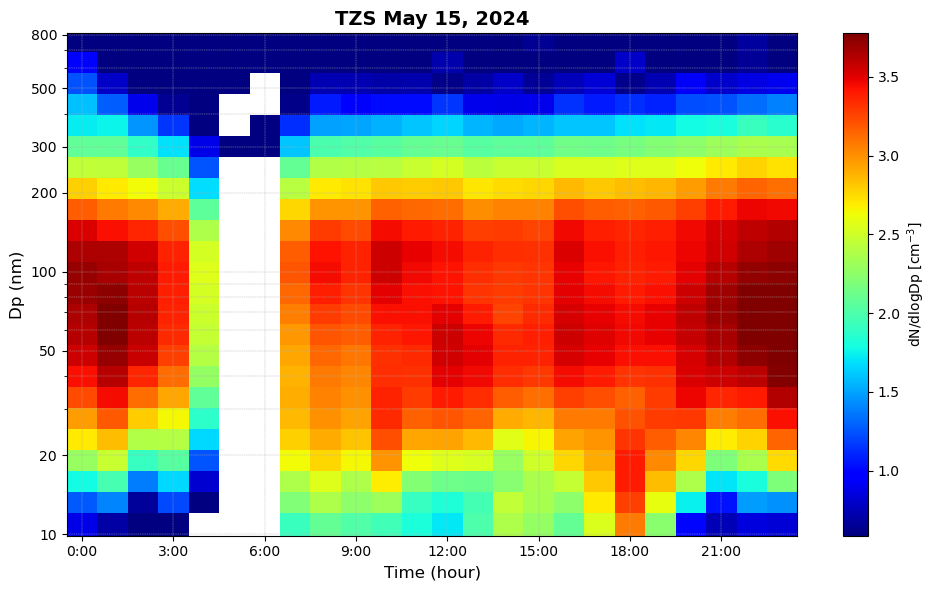

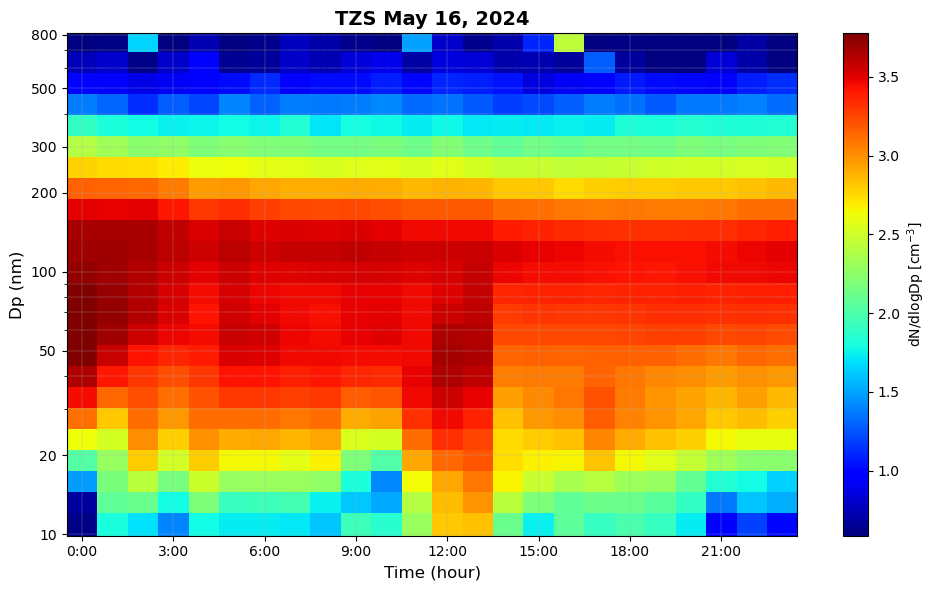

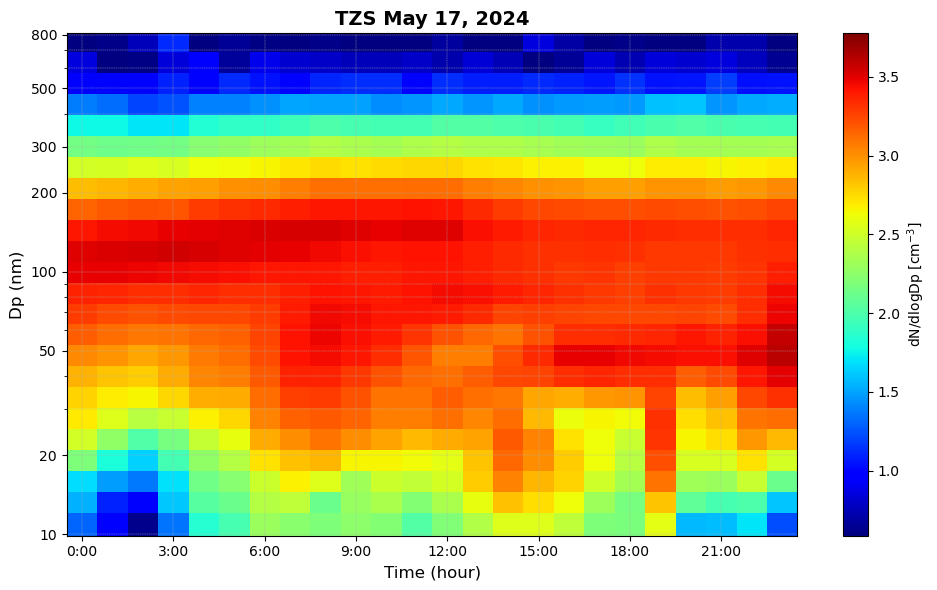

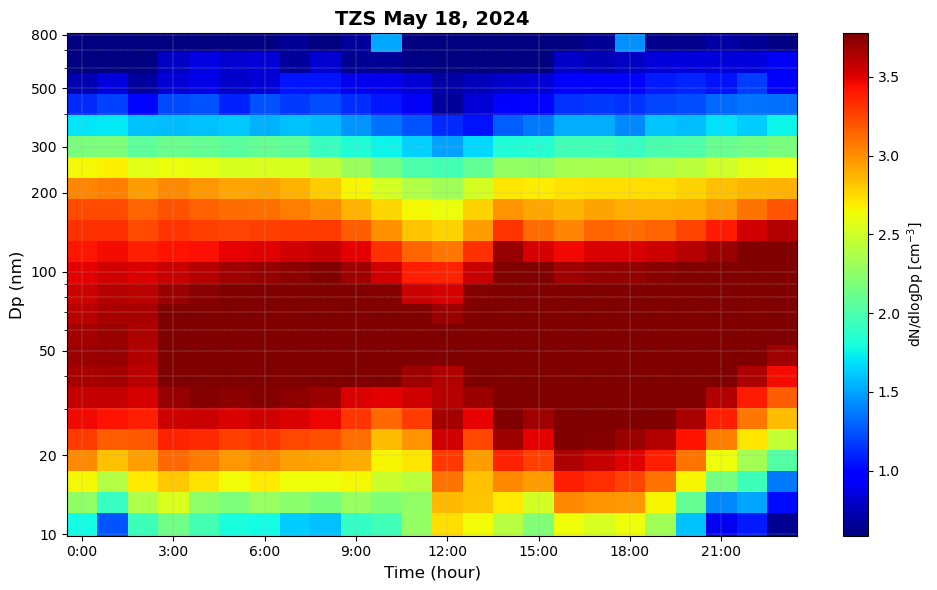

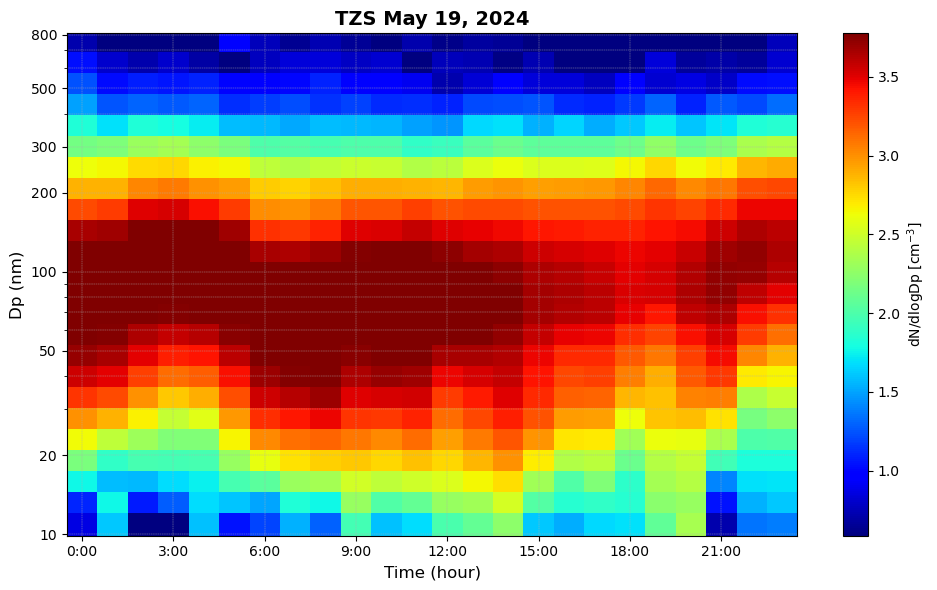

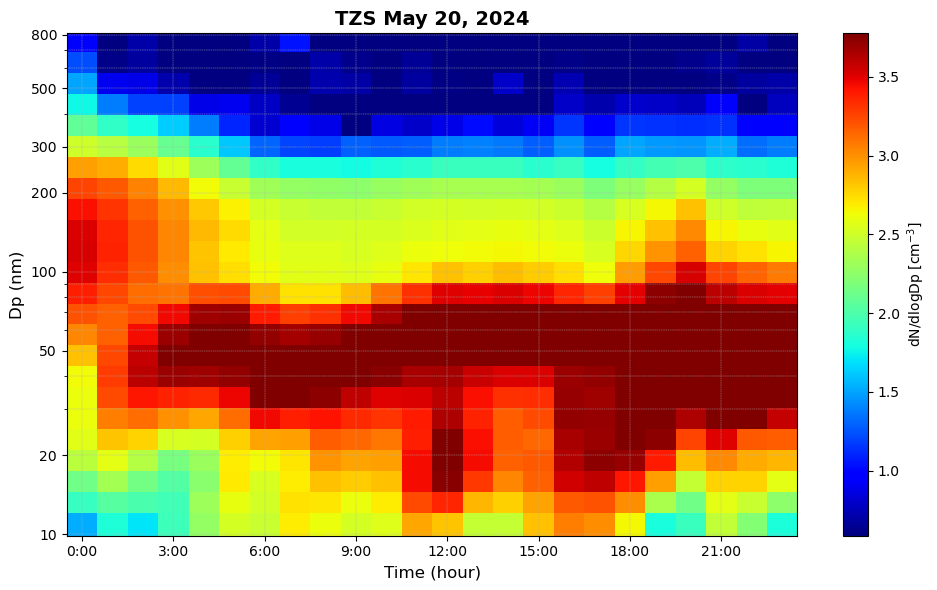

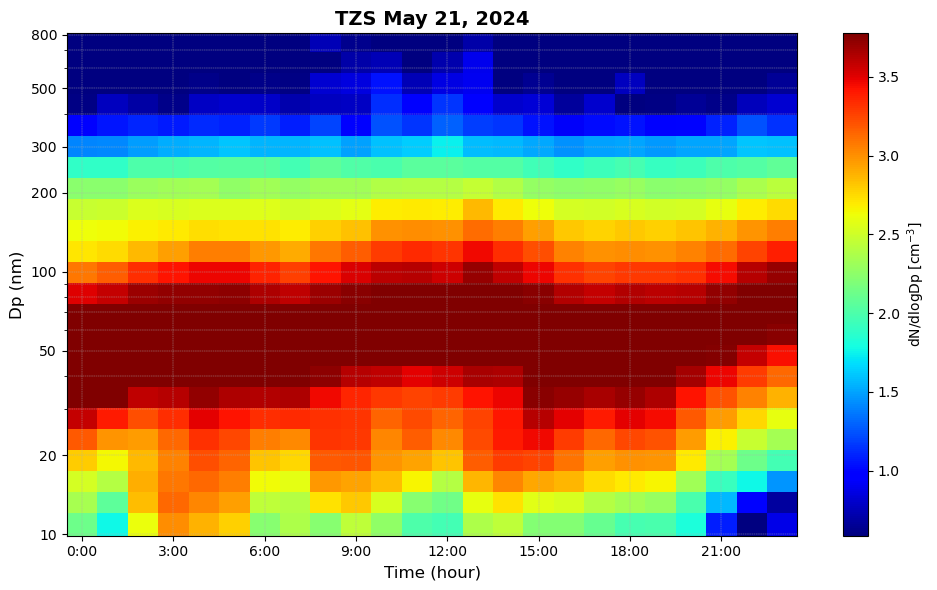

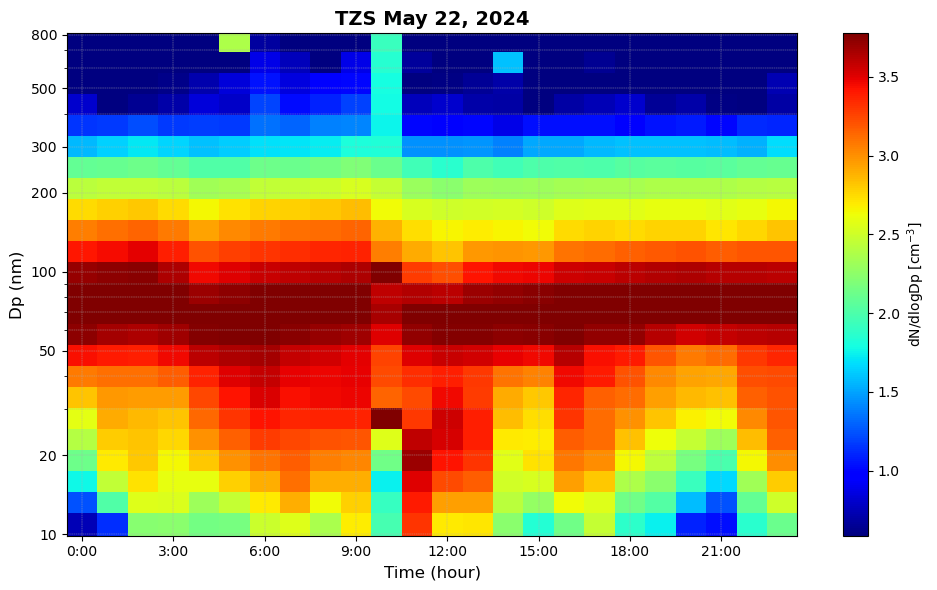

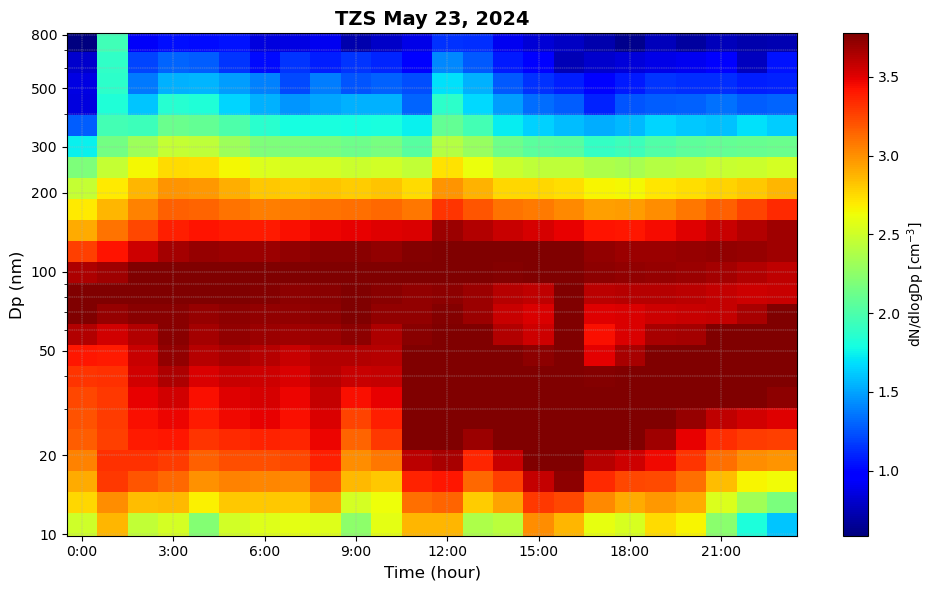

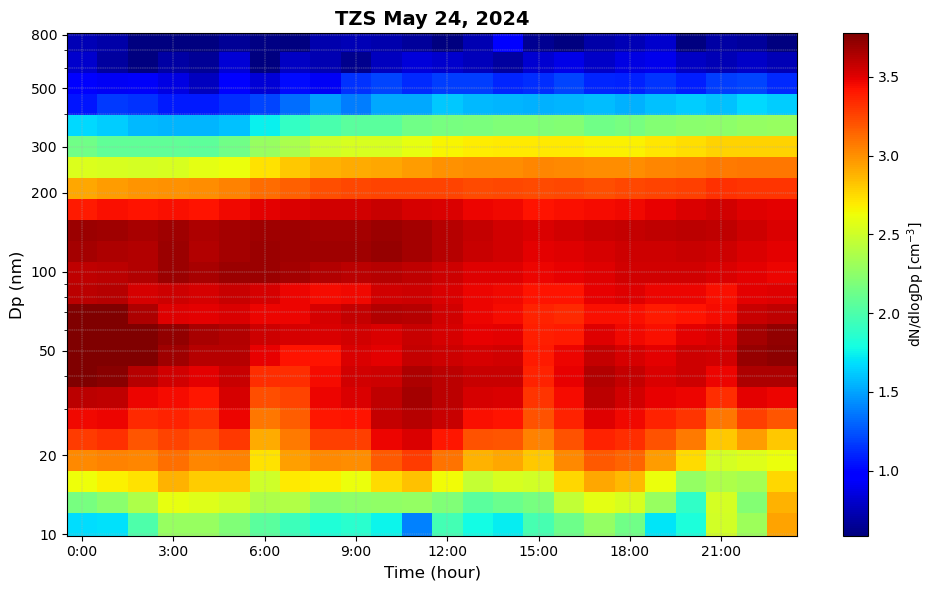

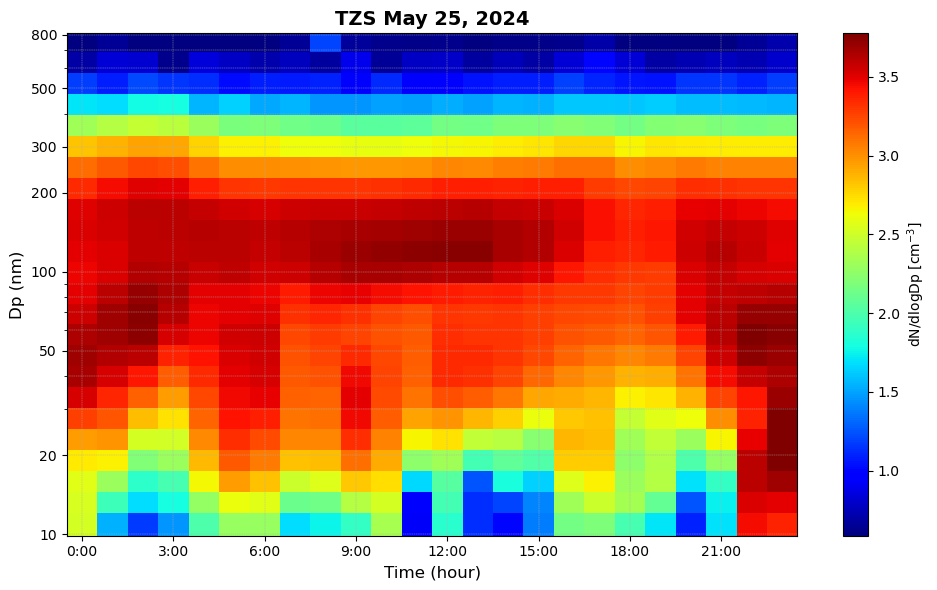

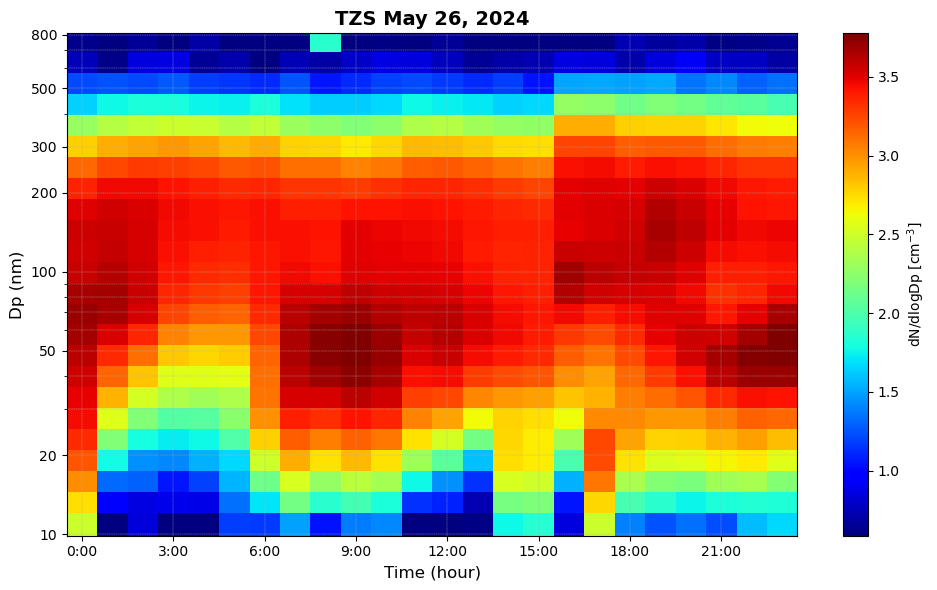

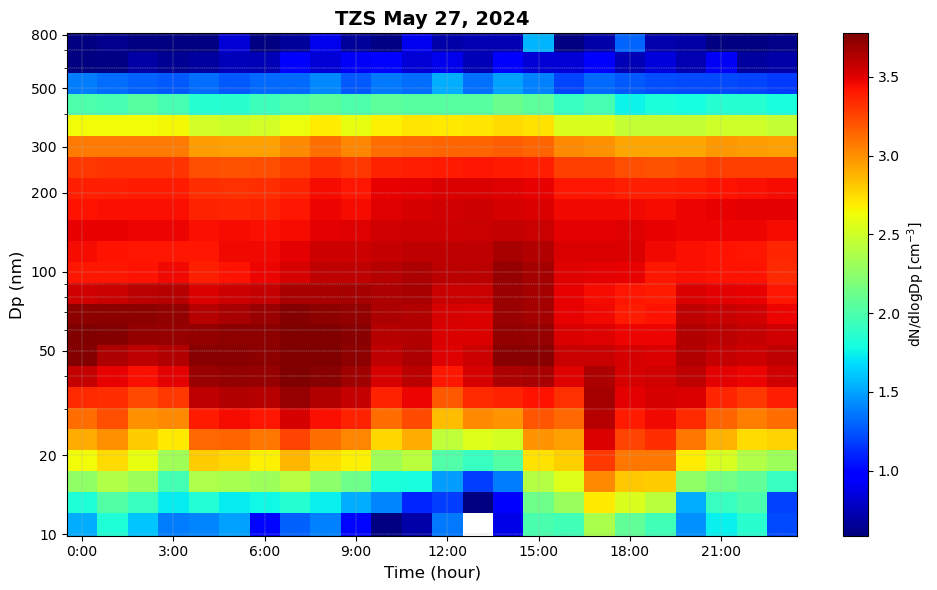

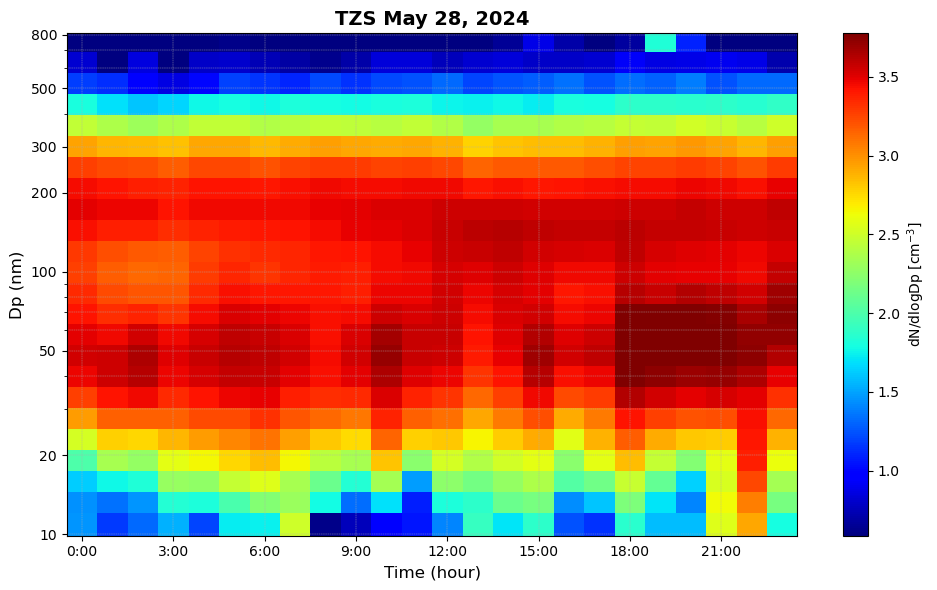

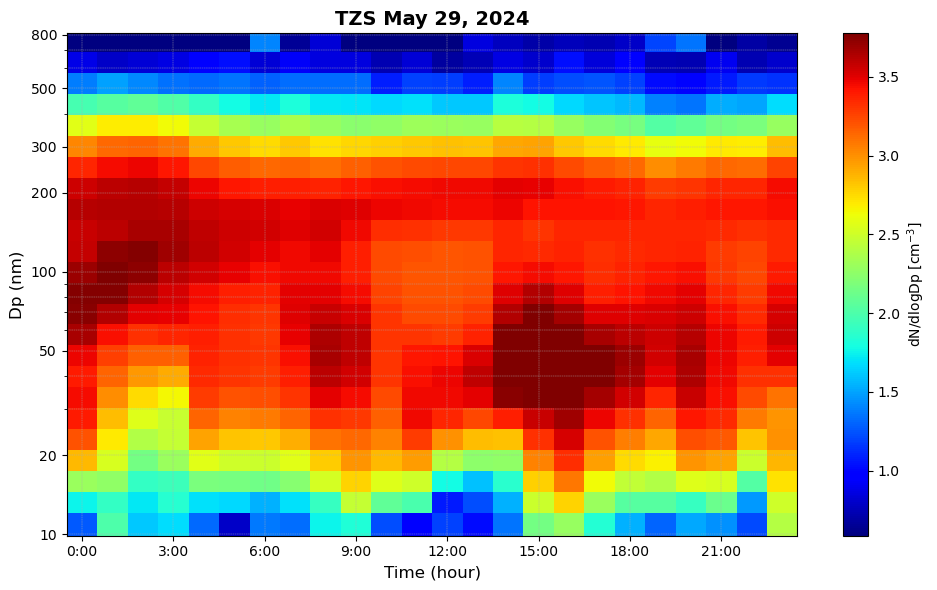

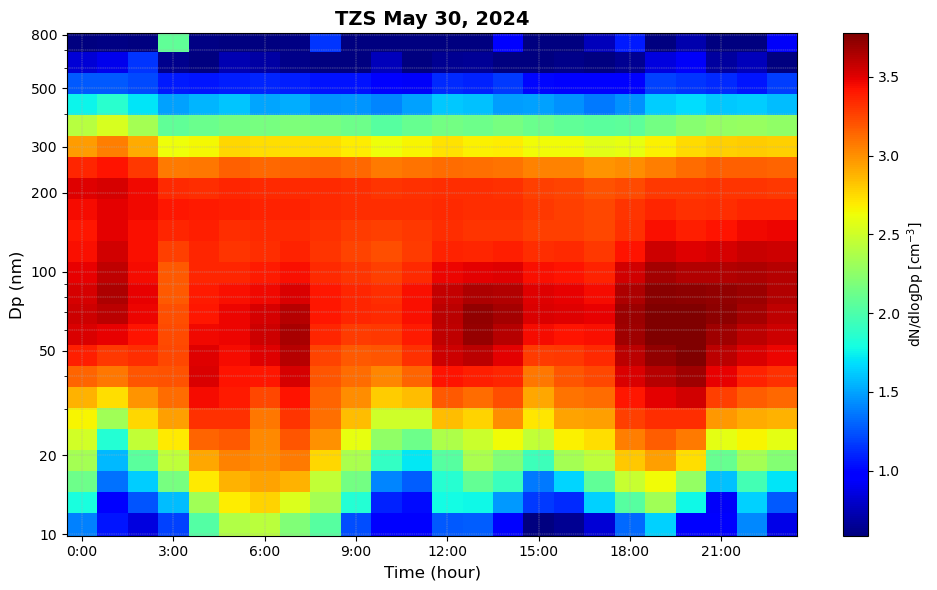

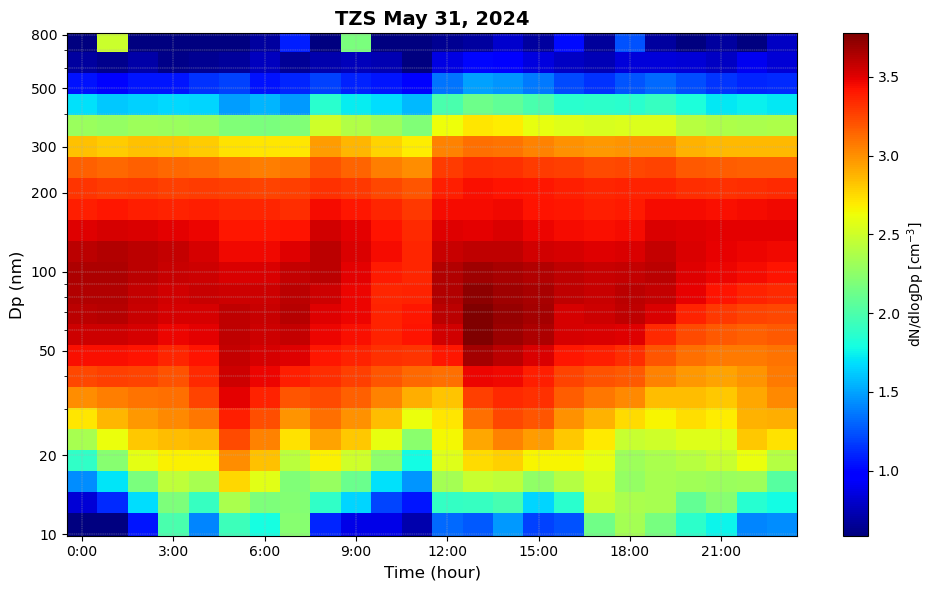

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Excel data
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)

# ---------------------------------------------------------------
# STEP 1: Extract bin edges and compute geometric midpoints (Dp)
# ---------------------------------------------------------------
bin_edges_m = tzs_data.columns.astype(float).to_numpy()           # in meters
bin_edges_nm = bin_edges_m * 1e9                                  # convert to nanometers
bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])  # geometric midpoints

# ---------------------------------------------------------------
# STEP 2: Prepare TZS data for May, remove 0s, and use midpoints
# ---------------------------------------------------------------
tzs_may = tzs_data[tzs_data.index.month == 5].replace(0, np.nan)
tzs_may.columns = bin_edges_nm                                    # assign bin edges temporarily
tzs_may_trimmed = tzs_may.iloc[:, 1:]                             # drop first edge column
tzs_log = np.log10(tzs_may_trimmed)                               # log-transform
tzs_log.columns = bin_midpoints_nm                                # use midpoints as column names

# ---------------------------------------------------------------
# STEP 3: Loop through each day in May
# ---------------------------------------------------------------
unique_days = tzs_log.index.normalize().unique()

for day in unique_days:
    daily_data = tzs_log[tzs_log.index.normalize() == day]
    hourly_mean = daily_data.groupby(daily_data.index.time).mean()

    # Ensure full 24-hour coverage
    time_index = pd.date_range("00:00", "23:00", freq="H").time
    hourly_mean = hourly_mean.reindex(time_index, fill_value=np.nan)

    # ---------------------------------------------------------------
    # STEP 4: Plotting (Frans-style)
    # ---------------------------------------------------------------
    X, Y = np.meshgrid(range(24), bin_midpoints_nm)

    vmin = np.nanpercentile(tzs_log.values, 5)
    vmax = np.nanpercentile(tzs_log.values, 95)

    custom_ticks = [10, 20, 50, 100, 200, 300, 500, 800]
    valid_ticks = sorted(set([10, 800] + [tick for tick in custom_ticks 
                                          if bin_midpoints_nm.min() <= tick <= bin_midpoints_nm.max()]))

    plt.figure(figsize=(10, 6))
    c = plt.pcolormesh(X, Y, hourly_mean.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
    plt.yscale('log')
    plt.colorbar(c, label=r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$')

    plt.title(f"TZS {day.strftime('%B %d, %Y')}", fontsize=14, fontweight='bold')
    plt.xlabel("Time (hour)", fontsize=12)
    plt.ylabel("Dp (nm)", fontsize=12)
    plt.xticks(range(0, 24, 3), [f"{h}:00" for h in range(0, 24, 3)])
    plt.yticks(valid_ticks, [str(t) for t in valid_ticks])
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

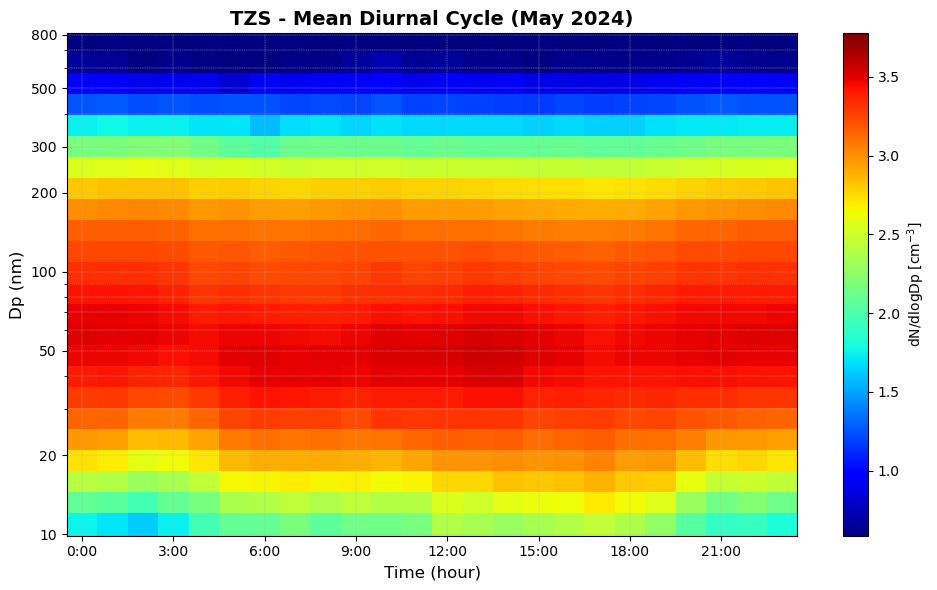

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Excel data
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)

# ---------------------------------------------------------------
# STEP 1: Extract bin edges and compute geometric midpoints (Dp)
# ---------------------------------------------------------------
bin_edges_m = tzs_data.columns.astype(float).to_numpy()           # in meters
bin_edges_nm = bin_edges_m * 1e9                                  # convert to nanometers
bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])  # geometric midpoints

# ---------------------------------------------------------------
# STEP 2: Prepare TZS data for May, remove 0s, and use midpoints
# ---------------------------------------------------------------
tzs_may = tzs_data[tzs_data.index.month == 5].replace(0, np.nan)
tzs_may.columns = bin_edges_nm                                    # assign bin edges temporarily
tzs_may_trimmed = tzs_may.iloc[:, 1:]                             # drop first edge column
tzs_log = np.log10(tzs_may_trimmed)                               # log-transform
tzs_log.columns = bin_midpoints_nm                                # use midpoints as column names

# ---------------------------------------------------------------
# STEP 3: Compute hourly mean across all May data
# ---------------------------------------------------------------
hourly_mean = tzs_log.groupby(tzs_log.index.time).mean()

# Ensure full 24-hour coverage
time_index = pd.date_range("00:00", "23:00", freq="H").time
hourly_mean = hourly_mean.reindex(time_index, fill_value=np.nan)

# ---------------------------------------------------------------
# STEP 4: Plotting (Frans-style)
# ---------------------------------------------------------------
X, Y = np.meshgrid(range(24), bin_midpoints_nm)

vmin = np.nanpercentile(tzs_log.values, 5)
vmax = np.nanpercentile(tzs_log.values, 95)

custom_ticks = [10, 20, 50, 100, 200, 300, 500, 800]
valid_ticks = sorted(set([10, 800] + [tick for tick in custom_ticks 
                                      if bin_midpoints_nm.min() <= tick <= bin_midpoints_nm.max()]))

plt.figure(figsize=(10, 6))
c = plt.pcolormesh(X, Y, hourly_mean.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
plt.yscale('log')
plt.colorbar(c, label=r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$')

plt.title("TZS - Mean Diurnal Cycle (May 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Time (hour)", fontsize=12)
plt.ylabel("Dp (nm)", fontsize=12)
plt.xticks(range(0, 24, 3), [f"{h}:00" for h in range(0, 24, 3)])
plt.yticks(valid_ticks, [str(t) for t in valid_ticks])
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

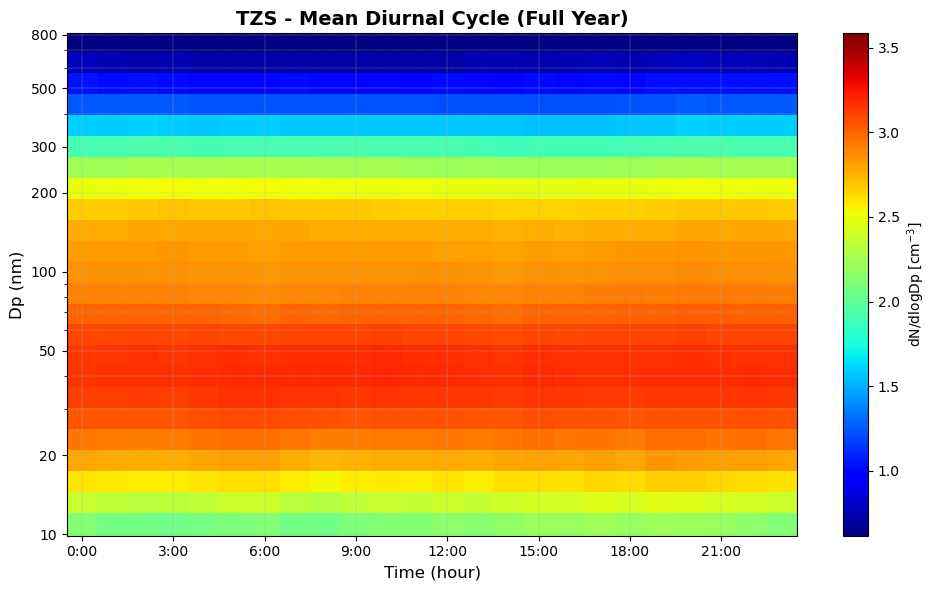

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Excel data
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)

# ---------------------------------------------------------------
# STEP 1: Extract bin edges and compute geometric midpoints (Dp)
# ---------------------------------------------------------------
bin_edges_m = tzs_data.columns.astype(float).to_numpy()           # in meters
bin_edges_nm = bin_edges_m * 1e9                                  # convert to nanometers
bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])  # geometric midpoints

# ---------------------------------------------------------------
# STEP 2: Prepare TZS data (whole year), remove 0s, and use midpoints
# ---------------------------------------------------------------
tzs_all = tzs_data.replace(0, np.nan)                             # keep entire year
tzs_all.columns = bin_edges_nm                                    # assign bin edges temporarily
tzs_all_trimmed = tzs_all.iloc[:, 1:]                             # drop first edge column
tzs_log = np.log10(tzs_all_trimmed)                               # log-transform
tzs_log.columns = bin_midpoints_nm                                # use midpoints as column names

# ---------------------------------------------------------------
# STEP 3: Compute hourly mean across entire year
# ---------------------------------------------------------------
hourly_mean = tzs_log.groupby(tzs_log.index.time).mean()

# Ensure full 24-hour coverage
time_index = pd.date_range("00:00", "23:00", freq="H").time
hourly_mean = hourly_mean.reindex(time_index, fill_value=np.nan)

# ---------------------------------------------------------------
# STEP 4: Plotting (Frans-style)
# ---------------------------------------------------------------
X, Y = np.meshgrid(range(24), bin_midpoints_nm)

vmin = np.nanpercentile(tzs_log.values, 5)
vmax = np.nanpercentile(tzs_log.values, 95)

custom_ticks = [10, 20, 50, 100, 200, 300, 500, 800]
valid_ticks = sorted(set([10, 800] + [tick for tick in custom_ticks 
                                      if bin_midpoints_nm.min() <= tick <= bin_midpoints_nm.max()]))

plt.figure(figsize=(10, 6))
c = plt.pcolormesh(X, Y, hourly_mean.T, cmap='jet', shading='auto', vmin=vmin, vmax=vmax)
plt.yscale('log')
plt.colorbar(c, label=r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$')

plt.title("TZS - Mean Diurnal Cycle (Full Year)", fontsize=14, fontweight='bold')
plt.xlabel("Time (hour)", fontsize=12)
plt.ylabel("Dp (nm)", fontsize=12)
plt.xticks(range(0, 24, 3), [f"{h}:00" for h in range(0, 24, 3)])
plt.yticks(valid_ticks, [str(t) for t in valid_ticks])
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

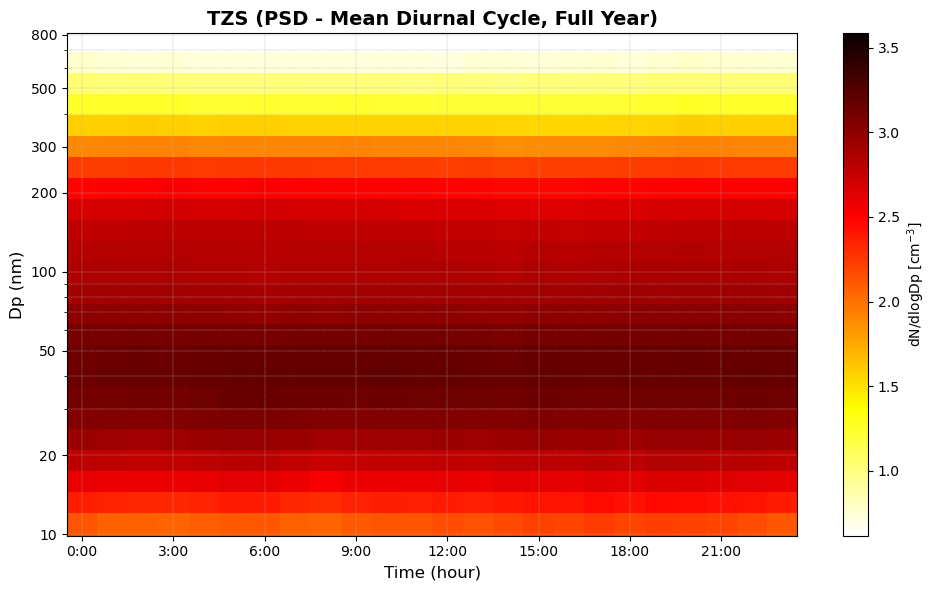

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Load Excel data
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)

# ---------------------------------------------------------------
# STEP 1: Extract bin edges and compute geometric midpoints (Dp)
# ---------------------------------------------------------------
bin_edges_m = tzs_data.columns.astype(float).to_numpy()
bin_edges_nm = bin_edges_m * 1e9
bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])

# ---------------------------------------------------------------
# STEP 2: Prepare TZS data for the whole year, remove 0s, and use midpoints
# ---------------------------------------------------------------
tzs_all = tzs_data.replace(0, np.nan)          # full year
tzs_all.columns = bin_edges_nm
tzs_all_trimmed = tzs_all.iloc[:, 1:]          # drop first edge column
tzs_log = np.log10(tzs_all_trimmed)
tzs_log.columns = bin_midpoints_nm

# ---------------------------------------------------------------
# STEP 3: Compute hourly mean across entire year
# ---------------------------------------------------------------
hourly_mean = tzs_log.groupby(tzs_log.index.time).mean()

# Ensure full 24-hour coverage
time_index = pd.date_range("00:00", "23:00", freq="H").time
hourly_mean = hourly_mean.reindex(time_index, fill_value=np.nan)

# ---------------------------------------------------------------
# STEP 4: Plotting using corrected size axis (Frans-style)
# ---------------------------------------------------------------
X, Y = np.meshgrid(range(24), bin_midpoints_nm)

# Reversed HOT colormap (dark = high concentration)
cmap_hot_r = plt.cm.get_cmap('hot_r')
vmin = np.nanpercentile(tzs_log.values, 5)
vmax = np.nanpercentile(tzs_log.values, 95)
norm_hot = colors.Normalize(vmin=vmin, vmax=vmax)

# Define Y-ticks
custom_ticks = [10, 20, 50, 100, 200, 300, 500, 800]
valid_ticks = sorted(set([10, 800] + [tick for tick in custom_ticks 
                                      if bin_midpoints_nm.min() <= tick <= bin_midpoints_nm.max()]))

# Plot
plt.figure(figsize=(10, 6))
c = plt.pcolormesh(X, Y, hourly_mean.T, cmap=cmap_hot_r, norm=norm_hot, shading='auto')
plt.yscale('log')
plt.colorbar(c, label=r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$')

plt.title("TZS (PSD - Mean Diurnal Cycle, Full Year)", fontsize=14, fontweight='bold')
plt.xlabel("Time (hour)", fontsize=12)
plt.ylabel("Dp (nm)", fontsize=12)
plt.xticks(range(0, 24, 3), [f"{h}:00" for h in range(0, 24, 3)])
plt.yticks(valid_ticks, [str(t) for t in valid_ticks])
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

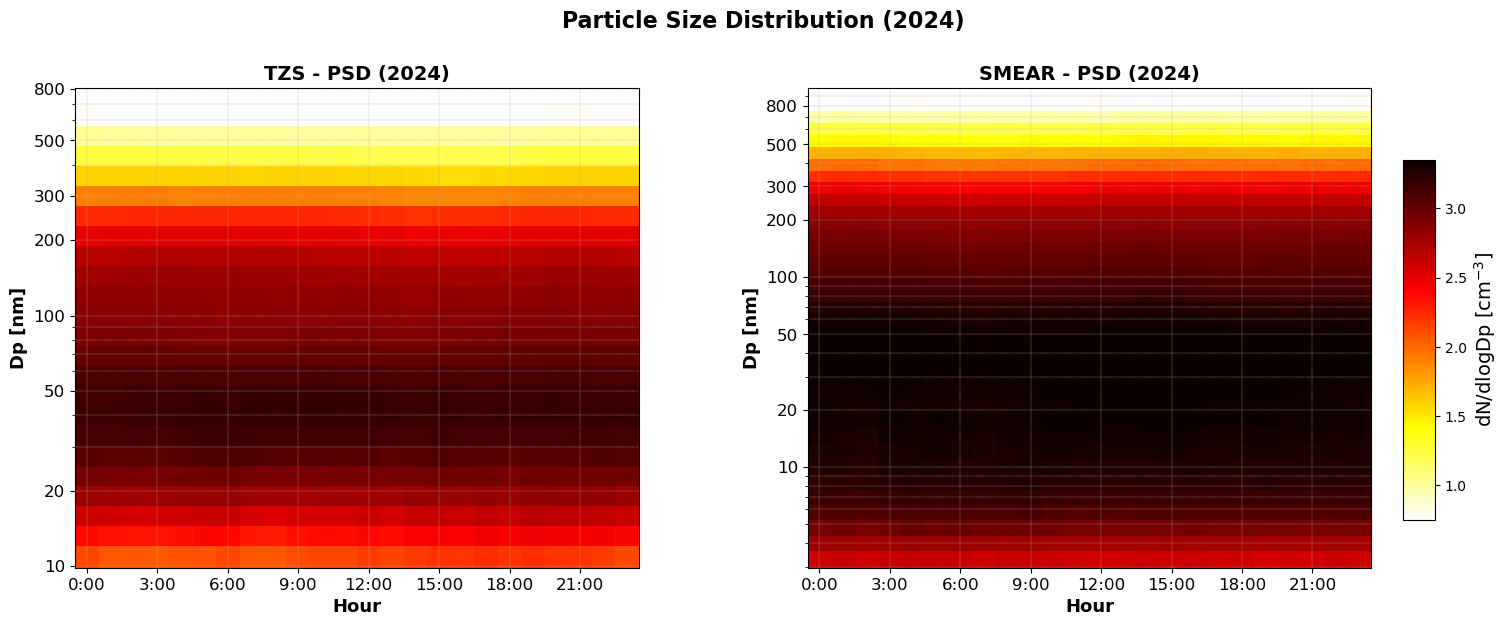

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === Load Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_data = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Function to process and extract PSD data with log10 dN/dlogDp ===
def process_psd_data(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]  # Drop first bin edge
    trimmed = trimmed.replace(0, np.nan)
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints_nm
    return log_data, bin_midpoints_nm

tzs_log, tzs_bins = process_psd_data(tzs_data)
smear_log, smear_bins = process_psd_data(smear_data)

# === Function to calculate diurnal average ===
def calculate_diurnal_average(log_data):
    hourly_avg = log_data.groupby(log_data.index.time).mean()
    time_index = pd.date_range("00:00", "23:00", freq="H").time
    hourly_avg = hourly_avg.reindex(time_index)
    return hourly_avg.T  # Transpose for heatmap

# Compute diurnal averages
tzs_diurnal = calculate_diurnal_average(tzs_log)
smear_diurnal = calculate_diurnal_average(smear_log)

# === Tick helper ===
def valid_ticks_from_bins(bins, custom_ticks):
    return sorted(set([custom_ticks[0], custom_ticks[-1]] + [t for t in custom_ticks if bins.min() <= t <= bins.max()]))

# === Tick values ===
tzs_ticks = valid_ticks_from_bins(tzs_bins, [10, 20, 50, 100, 200, 300, 500, 800])
smear_ticks = valid_ticks_from_bins(smear_bins, [10, 20, 50, 100, 200, 300, 500, 800])

# === Determine global color scale ===
combined_values = np.concatenate([
    tzs_diurnal.values.flatten(),
    smear_diurnal.values.flatten()
])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
cmap = plt.cm.get_cmap('hot_r')
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for ax, data, bins, label, ticks in [
    (axes[0], tzs_diurnal, tzs_bins, 'TZS', tzs_ticks),
    (axes[1], smear_diurnal, smear_bins, 'SMEAR', smear_ticks)
]:
    X, Y = np.meshgrid(range(24), bins)
    c = ax.pcolormesh(X, Y, data, cmap=cmap, norm=norm, shading='auto')
    ax.set_yscale('log')
    ax.set_xticks(range(0, 24, 3))
    ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 3)], fontsize=12)
    ax.set_yticks(ticks)
    ax.set_yticklabels([str(t) for t in ticks], fontsize=12)
    ax.set_xlabel("Hour", fontsize=13, weight='bold')
    ax.set_ylabel("Dp [nm]", fontsize=13, weight='bold')
    ax.set_title(f"{label} - PSD (2024)", fontsize=14, weight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.3)

# === Colorbar and Layout ===
plt.subplots_adjust(left=0.07, right=0.88, top=0.92, bottom=0.12, wspace=0.3)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=14, weight='bold')

# === Main Title moved slightly higher ===
plt.suptitle("Particle Size Distribution (2024)", fontsize=16, weight='bold', y=1.05)

plt.show()

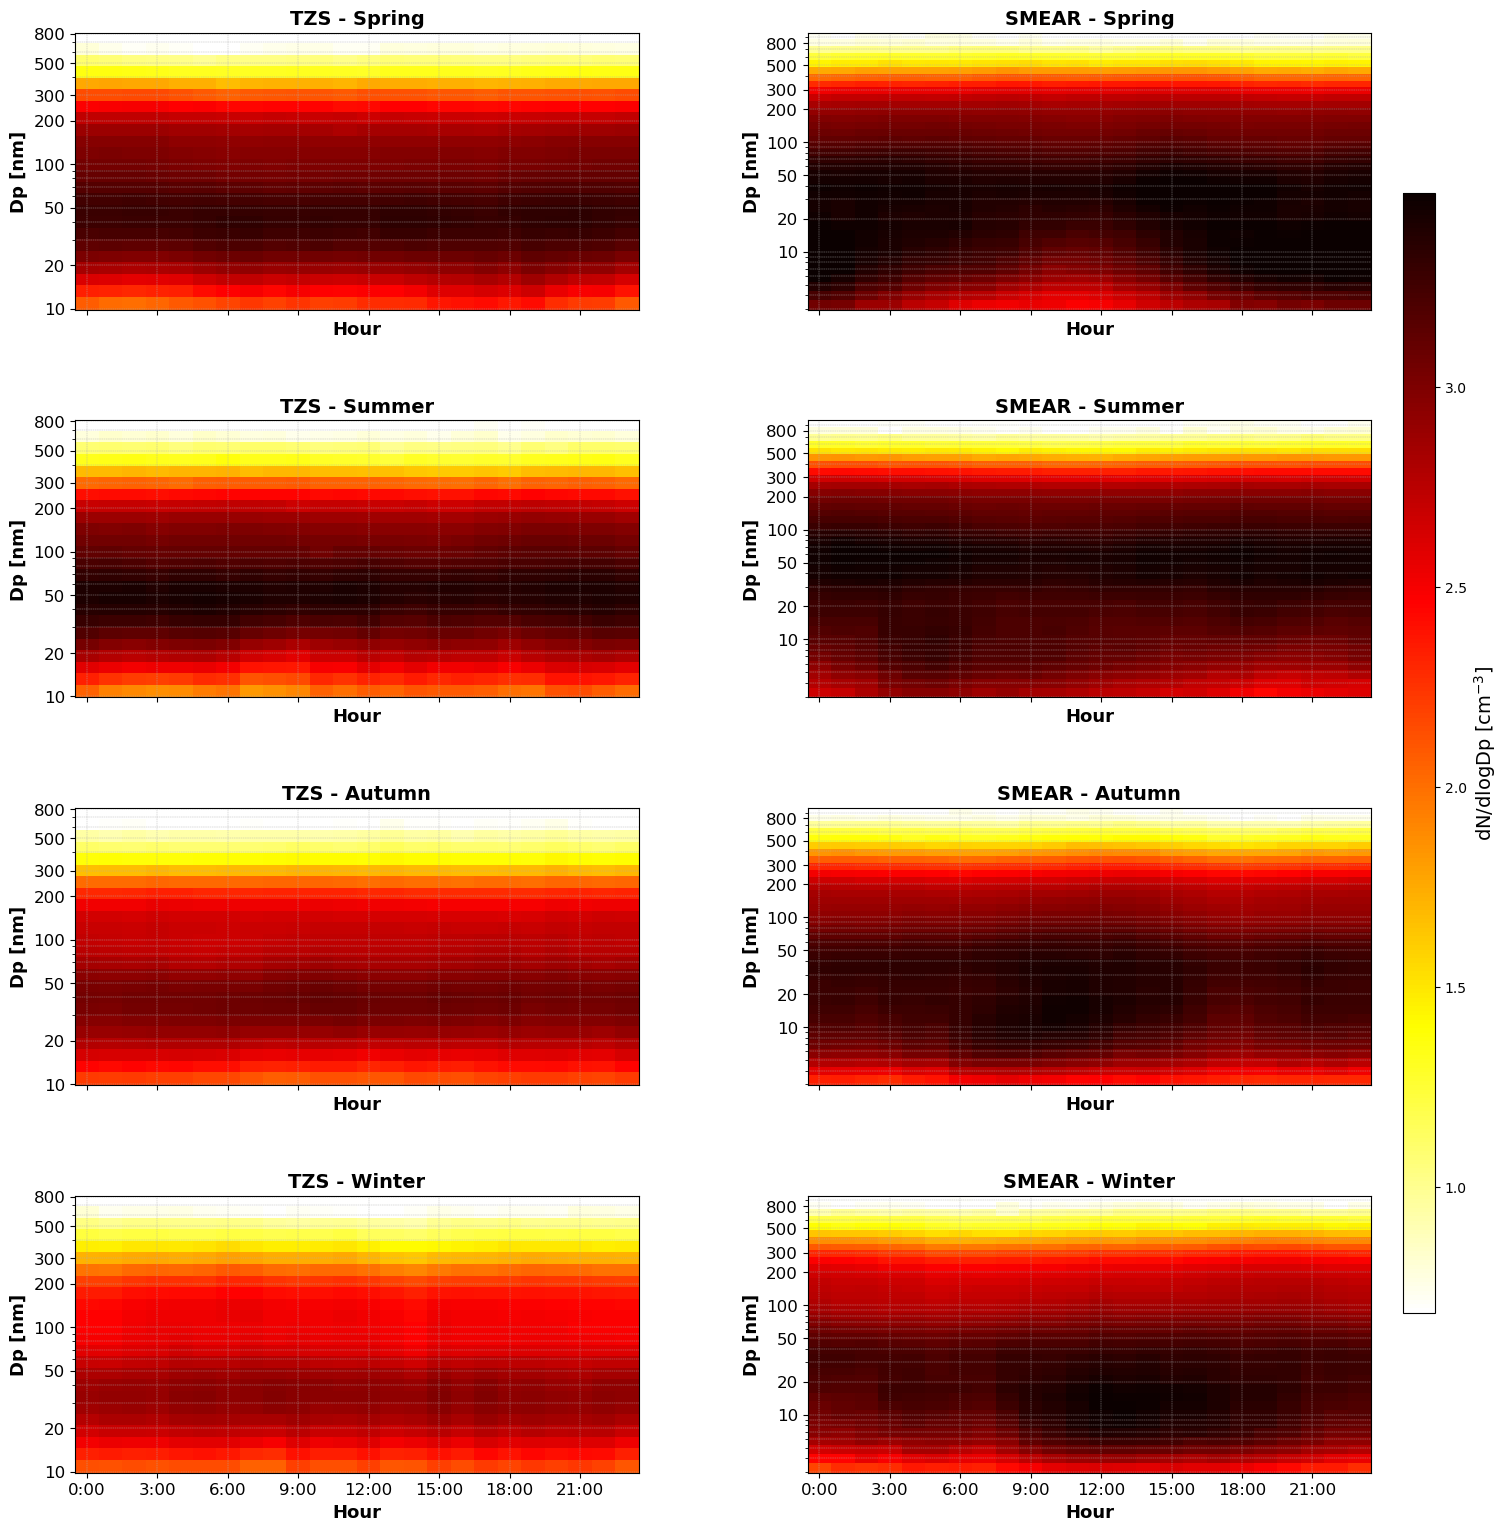

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === Load Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_data = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Function to process and extract PSD data with log10 dN/dlogDp ===
def process_psd_data(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]  # Drop first bin edge
    trimmed = trimmed.replace(0, np.nan)
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints_nm
    return log_data, bin_midpoints_nm

tzs_log, tzs_bins = process_psd_data(tzs_data)
smear_log, smear_bins = process_psd_data(smear_data)

# === Define Finnish Seasons ===
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2],
}

# === Function to prepare seasonal heatmap data ===
def prepare_seasonal_heatmaps(log_data, bins, seasons):
    seasonal_heatmaps = {}
    vmins, vmaxs = [], []
    for season, months in seasons.items():
        seasonal_data = log_data[log_data.index.month.isin(months)]
        hourly_avg = seasonal_data.groupby(seasonal_data.index.time).mean()
        time_index = pd.date_range("00:00", "23:00", freq="H").time
        hourly_avg = hourly_avg.reindex(time_index)
        seasonal_heatmaps[season] = hourly_avg.T
        vmins.append(np.nanpercentile(hourly_avg.values, 5))
        vmaxs.append(np.nanpercentile(hourly_avg.values, 95))
    return seasonal_heatmaps, bins, min(vmins), max(vmaxs)

tzs_seasonal, tzs_bins, tzs_vmin, tzs_vmax = prepare_seasonal_heatmaps(tzs_log, tzs_bins, seasons)
smear_seasonal, smear_bins, smear_vmin, smear_vmax = prepare_seasonal_heatmaps(smear_log, smear_bins, seasons)
vmin = min(tzs_vmin, smear_vmin)
vmax = max(tzs_vmax, smear_vmax)

# === Tick helper ===
def valid_ticks_from_bins(bins, custom_ticks):
    return sorted(set([custom_ticks[0], custom_ticks[-1]] + [t for t in custom_ticks if bins.min() <= t <= bins.max()]))

# === Tick values ===
tzs_ticks = valid_ticks_from_bins(tzs_bins, [10, 20, 50, 100, 200, 300, 500, 800])
smear_ticks = valid_ticks_from_bins(smear_bins, [10, 20, 50, 100, 200, 300, 500, 800])

# === Plotting ===
fig, axes = plt.subplots(4, 2, figsize=(16, 16), sharex=True)
ordered_seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
cmap = plt.cm.get_cmap('hot_r')
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for i, season in enumerate(ordered_seasons):
    for j, (data, bins, label, ticks) in enumerate([
        (tzs_seasonal[season], tzs_bins, 'TZS', tzs_ticks),
        (smear_seasonal[season], smear_bins, 'SMEAR', smear_ticks)
    ]):
        ax = axes[i, j]
        X, Y = np.meshgrid(range(24), bins)
        c = ax.pcolormesh(X, Y, data, cmap=cmap, norm=norm, shading='auto')
        ax.set_yscale('log')
        ax.set_xticks(range(0, 24, 3))
        ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 3)], fontsize=12)
        ax.set_yticks(ticks)
        ax.set_yticklabels([str(t) for t in ticks], fontsize=12)
        ax.set_xlabel("Hour", fontsize=13, weight='bold')
        ax.set_ylabel("Dp [nm]", fontsize=13, weight='bold')
        ax.set_title(f"{label} - {season}", fontsize=14, weight='bold')
        ax.grid(True, which='both', linestyle='--', linewidth=0.3)

# === Colorbar and Layout ===
plt.subplots_adjust(left=0.07, right=0.88, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=14, weight='bold')

plt.show()

/var/folders/4t/47wt24490m52zgk23b06kc9m0000gn/T/ipykernel_41128/3867708913.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.1, 0.97, 0.95])


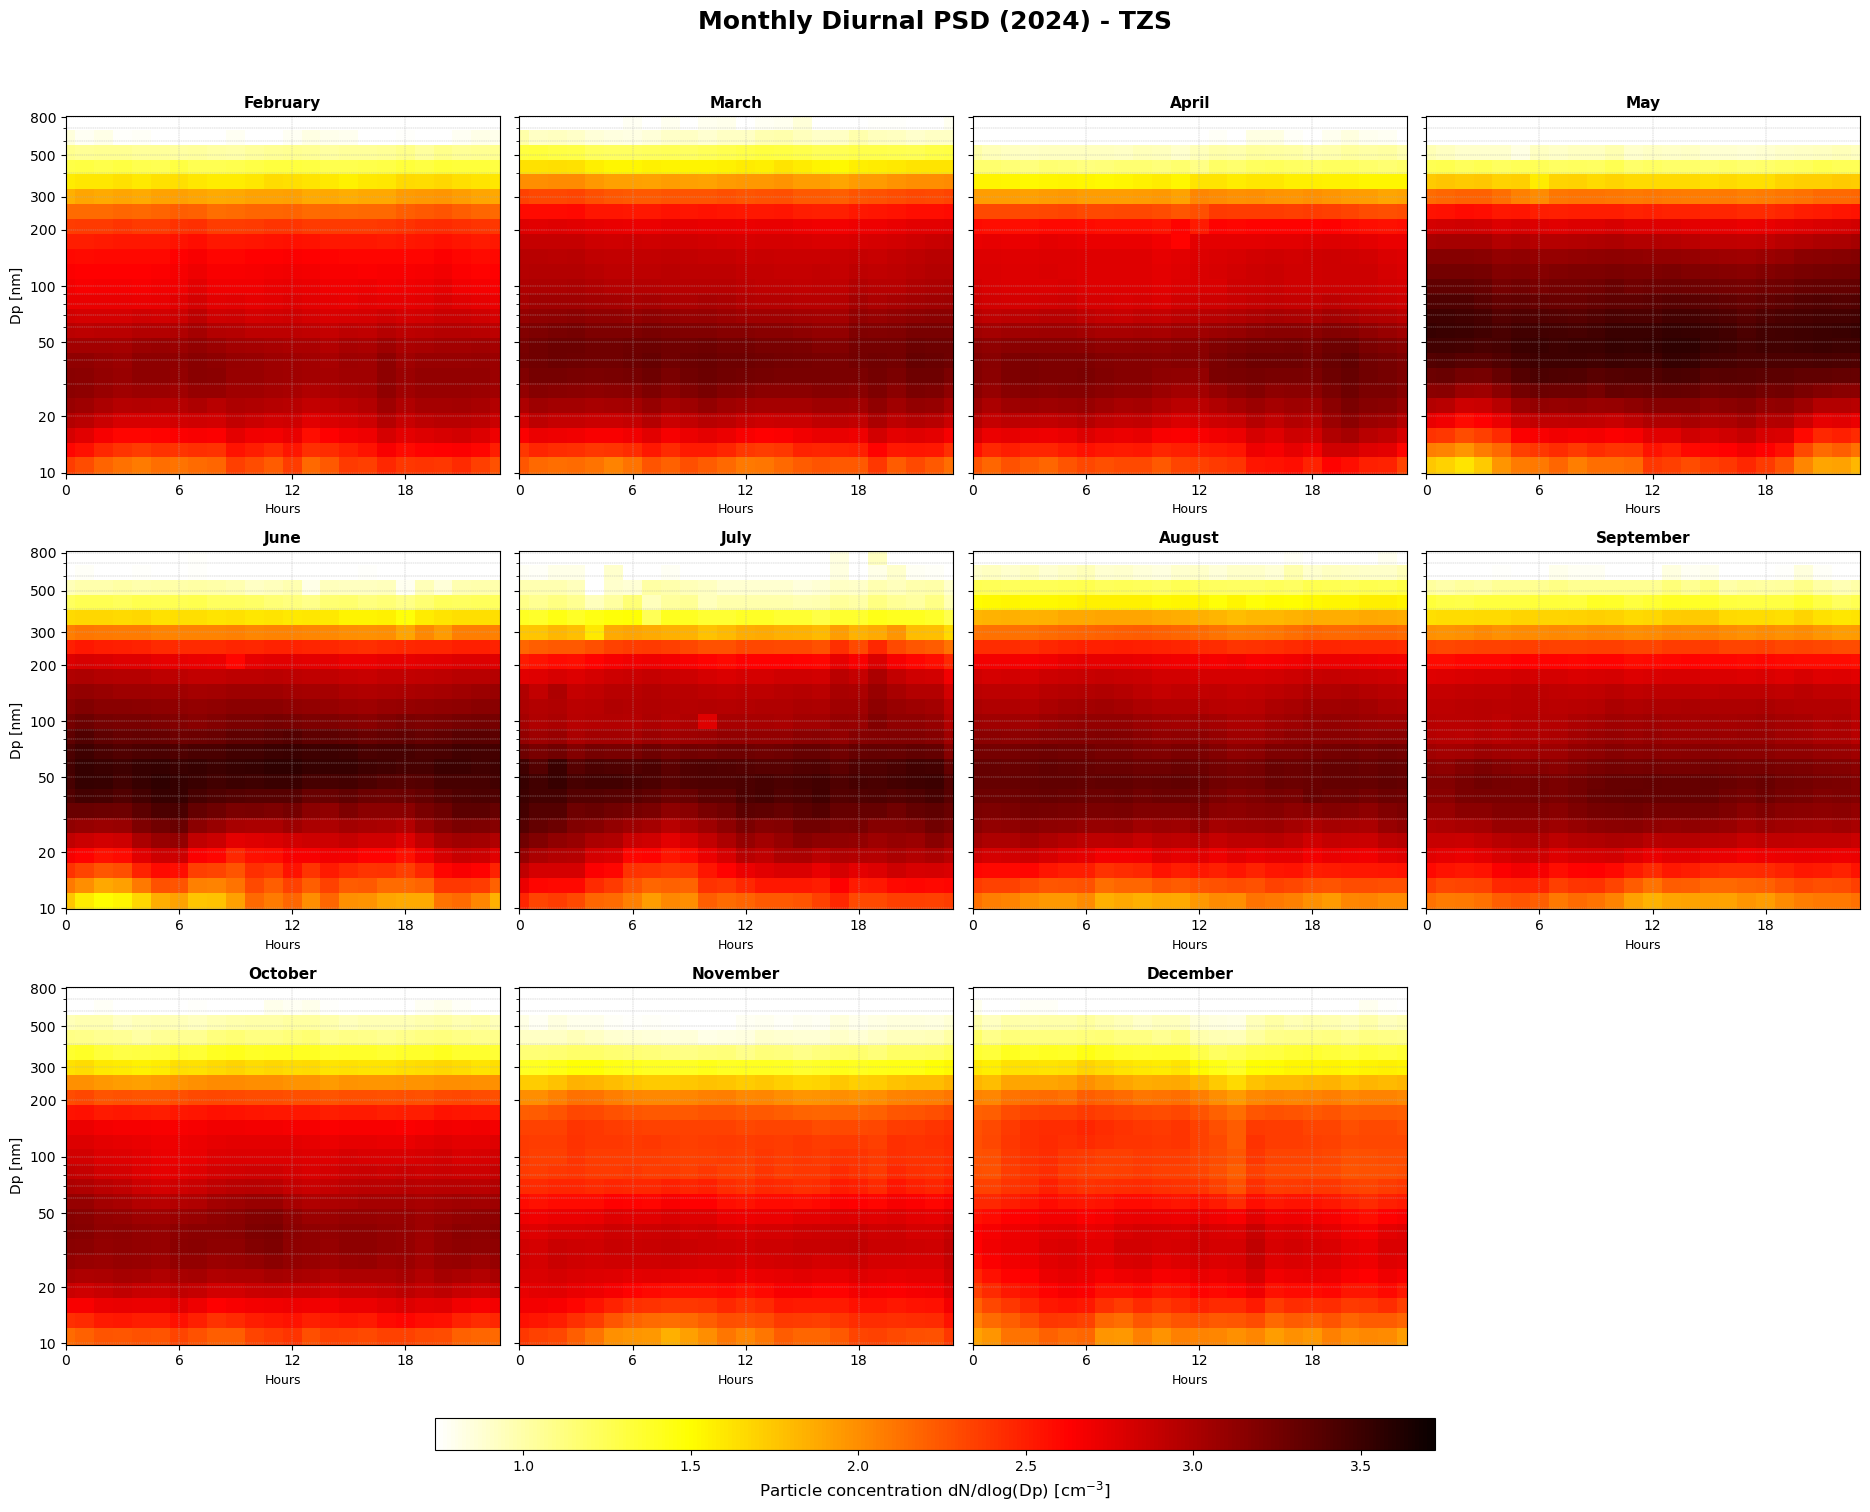

/var/folders/4t/47wt24490m52zgk23b06kc9m0000gn/T/ipykernel_41128/3867708913.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.1, 0.97, 0.95])


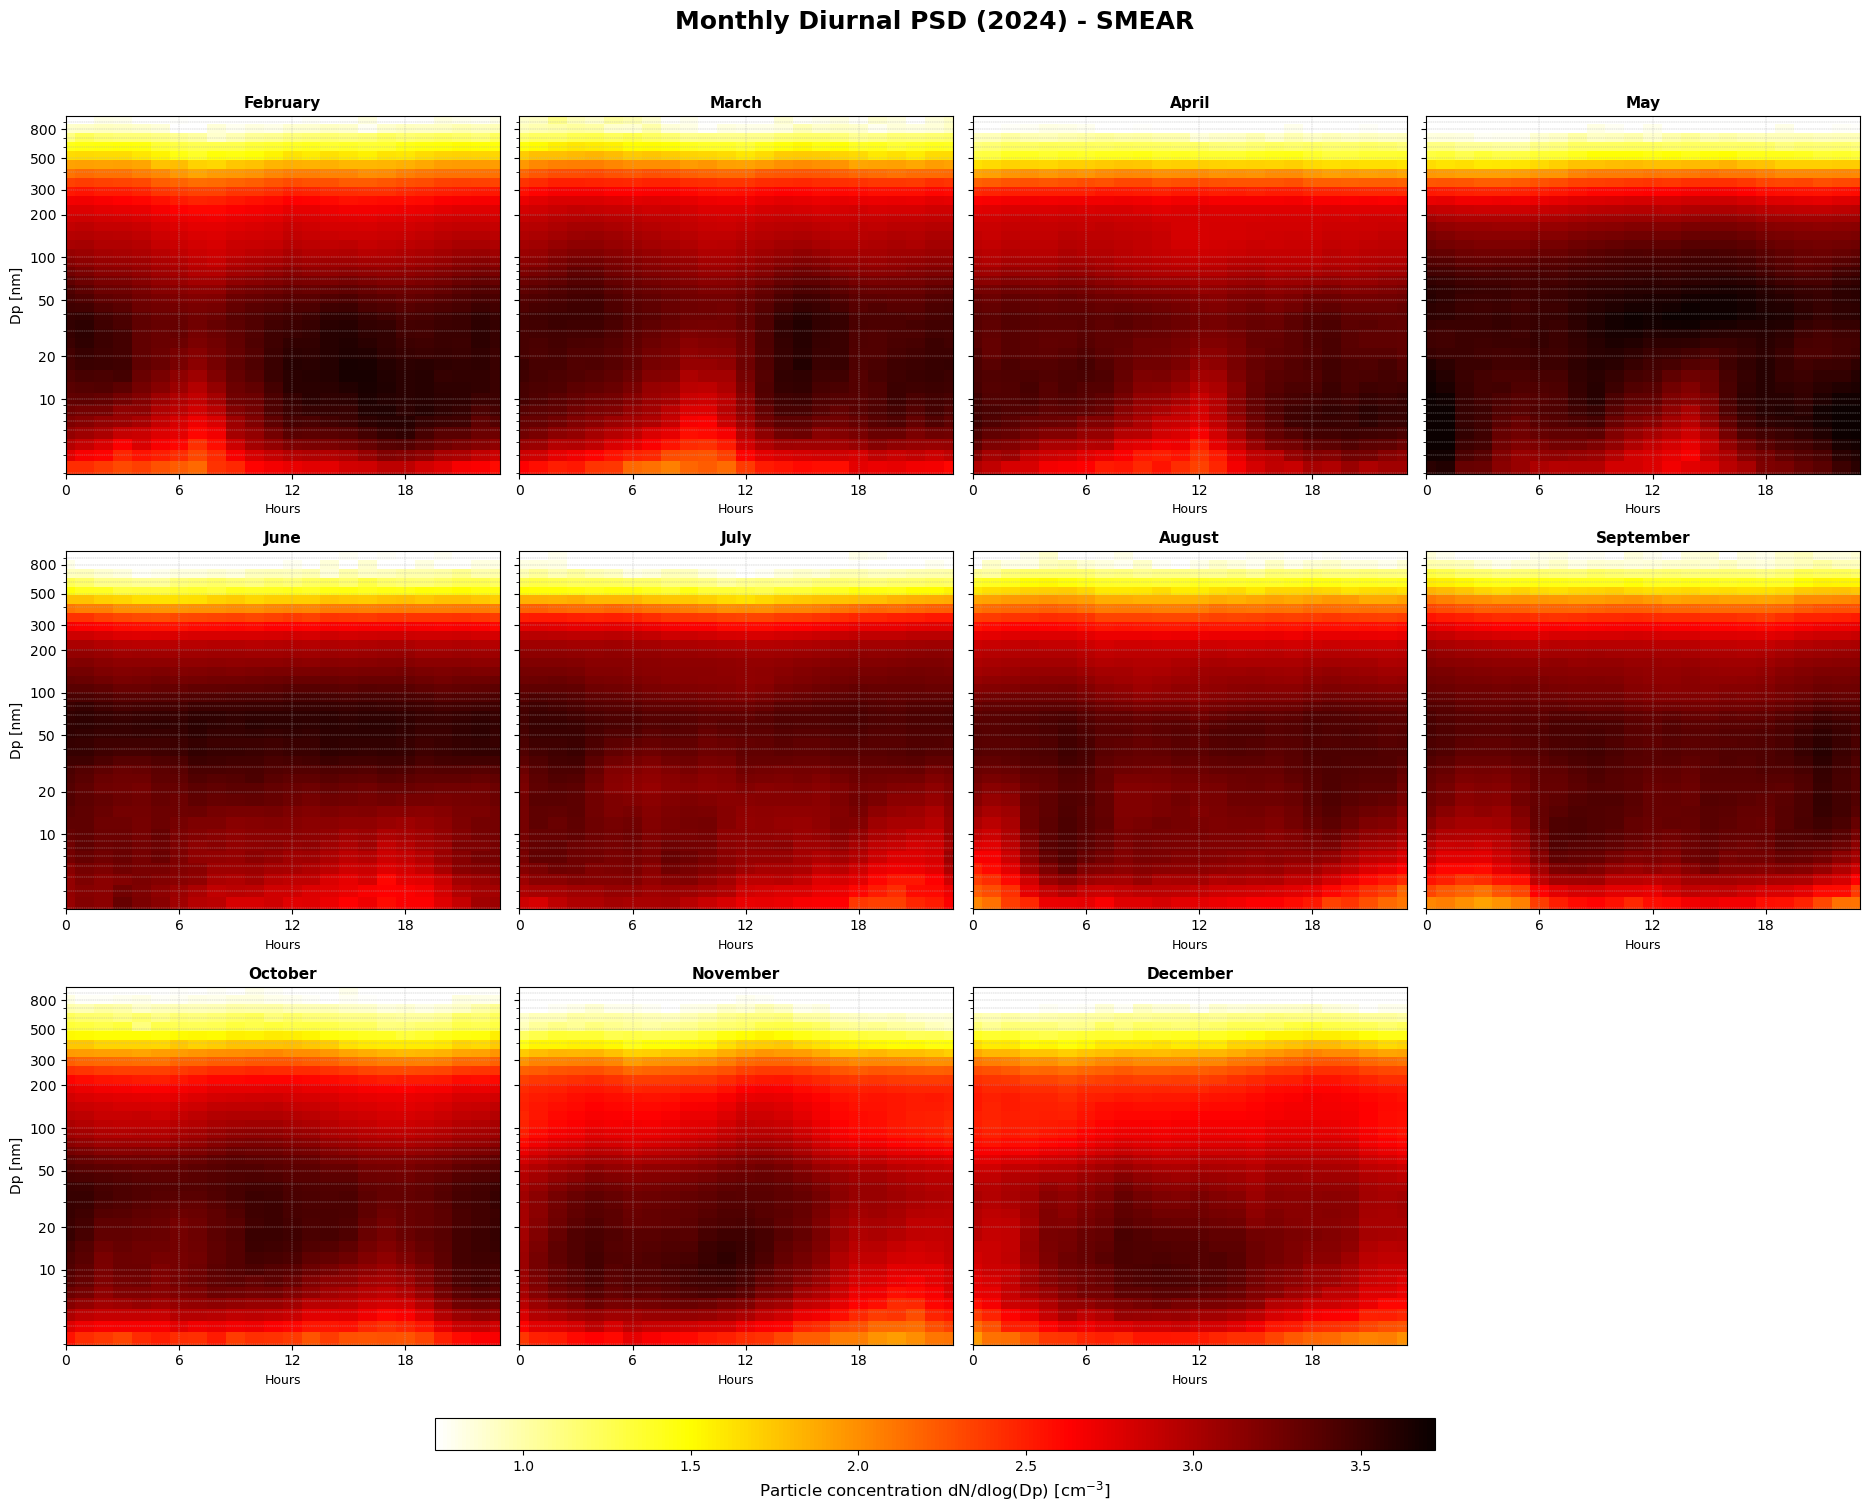

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# === Step 1: Load Excel Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_data = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_data = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Step 2: Process PSD Data ===
def process_psd_data(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints_nm = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]
    trimmed = trimmed.replace(0, np.nan)
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints_nm
    return log_data, bin_midpoints_nm

tzs_log, tzs_bins = process_psd_data(tzs_data)
smear_log, smear_bins = process_psd_data(smear_data)

# === Step 3: Define Y-axis Ticks ===
custom_ticks = [3, 10, 20, 50, 100, 200, 300, 500, 800, 1000]
ytick_pos = sorted(set([10, 800] + [t for t in custom_ticks if tzs_bins.min() <= t <= tzs_bins.max()]))
ytick_labels = [str(t) for t in ytick_pos]

# === Step 4: Compute Shared Color Scale ===
combined_values = np.concatenate([
    tzs_log.values.flatten(),
    smear_log.values.flatten()
])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.get_cmap('hot_r')

# === Step 5: Define Plotting Function ===
def plot_monthly_grid(fig_title, data, bins, months, ytick_pos, ytick_labels, site_label, norm, cmap):
    hours = list(range(24))
    X, Y = np.meshgrid(hours, bins)

    fig, axes = plt.subplots(3, 4, figsize=(20, 16), sharex=True, sharey=True)
    axes = axes.flatten()
    pcm = None

    for i, month in enumerate(months[:12]):
        ax = axes[i]
        month_data = data[data.index.to_period('M') == month]
        hourly_avg = month_data.groupby(month_data.index.time).mean()
        full_hours = pd.date_range("00:00", "23:00", freq="H").time
        hourly_avg = hourly_avg.reindex(full_hours, fill_value=np.nan)

        pcm = ax.pcolormesh(X, Y, hourly_avg.T, cmap=cmap, norm=norm, shading='auto')
        ax.set_yscale('log')
        ax.set_title(month.strftime('%B'), fontsize=11, fontweight='bold')

        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 6))
        ax.set_xticklabels([f"{h}" for h in range(0, 24, 6)])
        ax.tick_params(labelbottom=True)
        ax.set_xlabel("Hours", fontsize=9)

        ax.set_yticks(ytick_pos)
        ax.set_yticklabels(ytick_labels)
        ax.grid(True, which='both', linestyle='--', linewidth=0.3)

        if i % 4 == 0:
            ax.set_ylabel("Dp [nm]", fontsize=10)

    for j in range(len(months), len(axes)):
        axes[j].axis('off')

    # Shared Colorbar
    cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(r'Particle concentration dN/dlog(Dp) [cm$^{-3}$]', fontsize=12)

    # Title and layout
    fig.suptitle(fig_title, fontsize=18, fontweight='bold', y=0.97)
    plt.tight_layout(rect=[0.03, 0.1, 0.97, 0.95])
    plt.show()

# === Step 6: Get Months and Call Plots ===
months = sorted(tzs_log.index.to_period("M").unique())[:12]

# --- Page 1: TZS ---
plot_monthly_grid(
    fig_title="Monthly Diurnal PSD (2024) - TZS",
    data=tzs_log,
    bins=tzs_bins,
    months=months,
    ytick_pos=ytick_pos,
    ytick_labels=ytick_labels,
    site_label="TZS",
    norm=norm,
    cmap=cmap
)

# --- Page 2: SMEAR ---
plot_monthly_grid(
    fig_title="Monthly Diurnal PSD (2024) - SMEAR",
    data=smear_log,
    bins=smear_bins,
    months=months,
    ytick_pos=ytick_pos,
    ytick_labels=ytick_labels,
    site_label="SMEAR",
    norm=norm,
    cmap=cmap
)

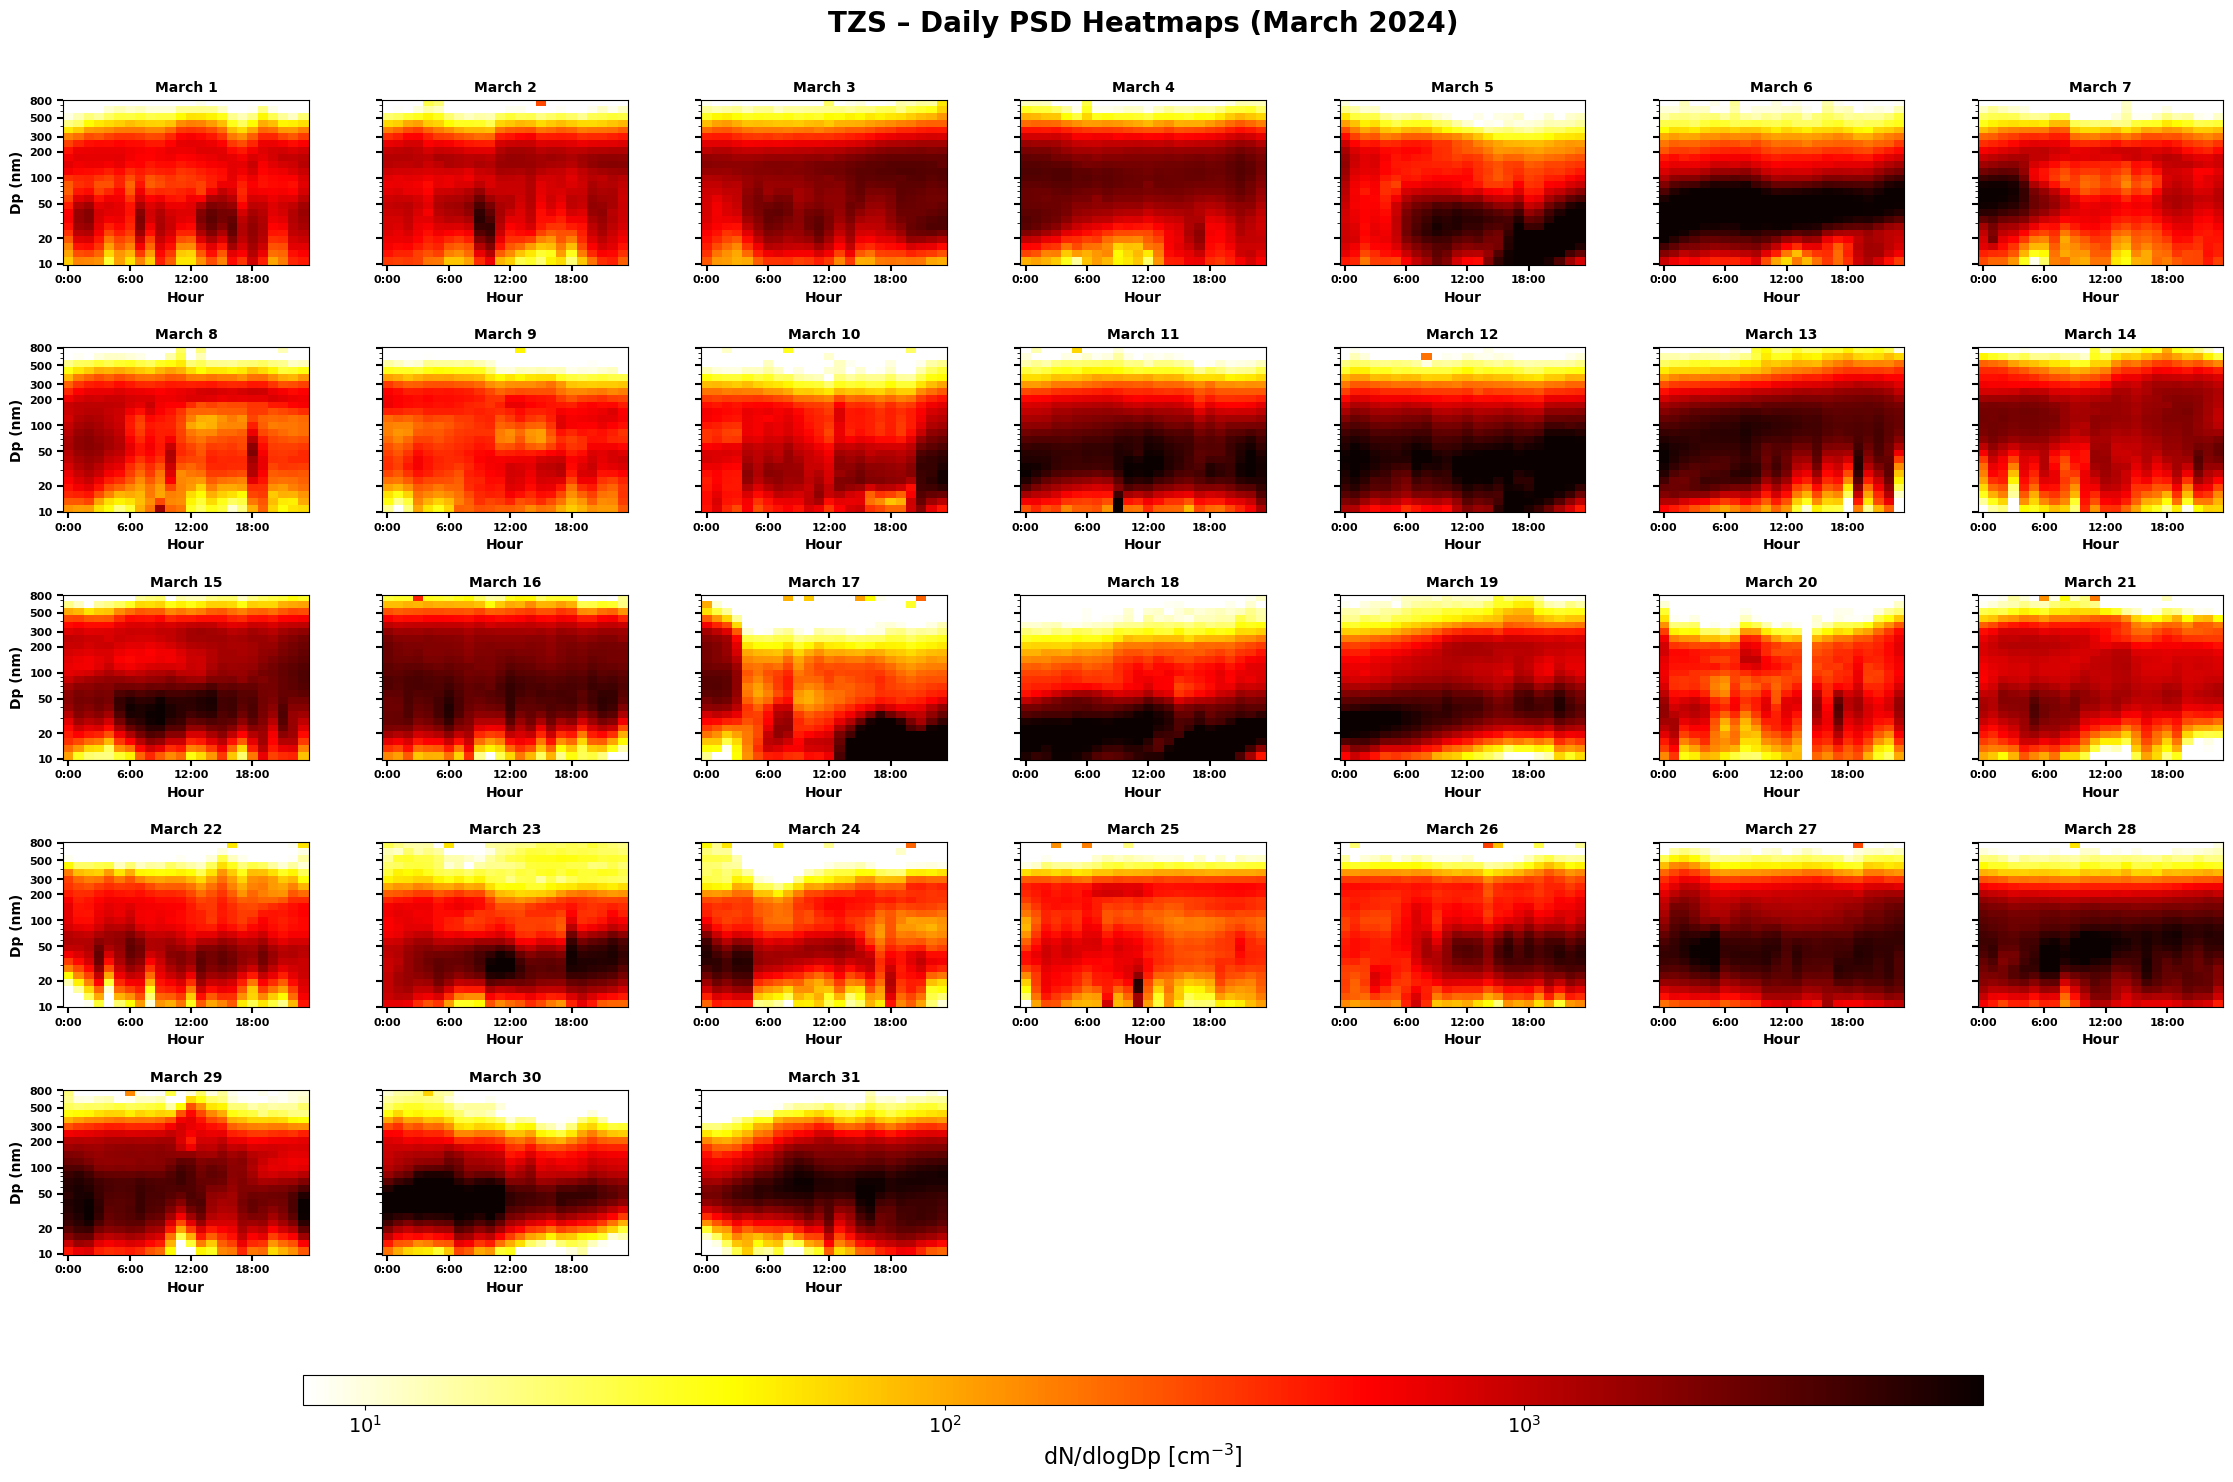

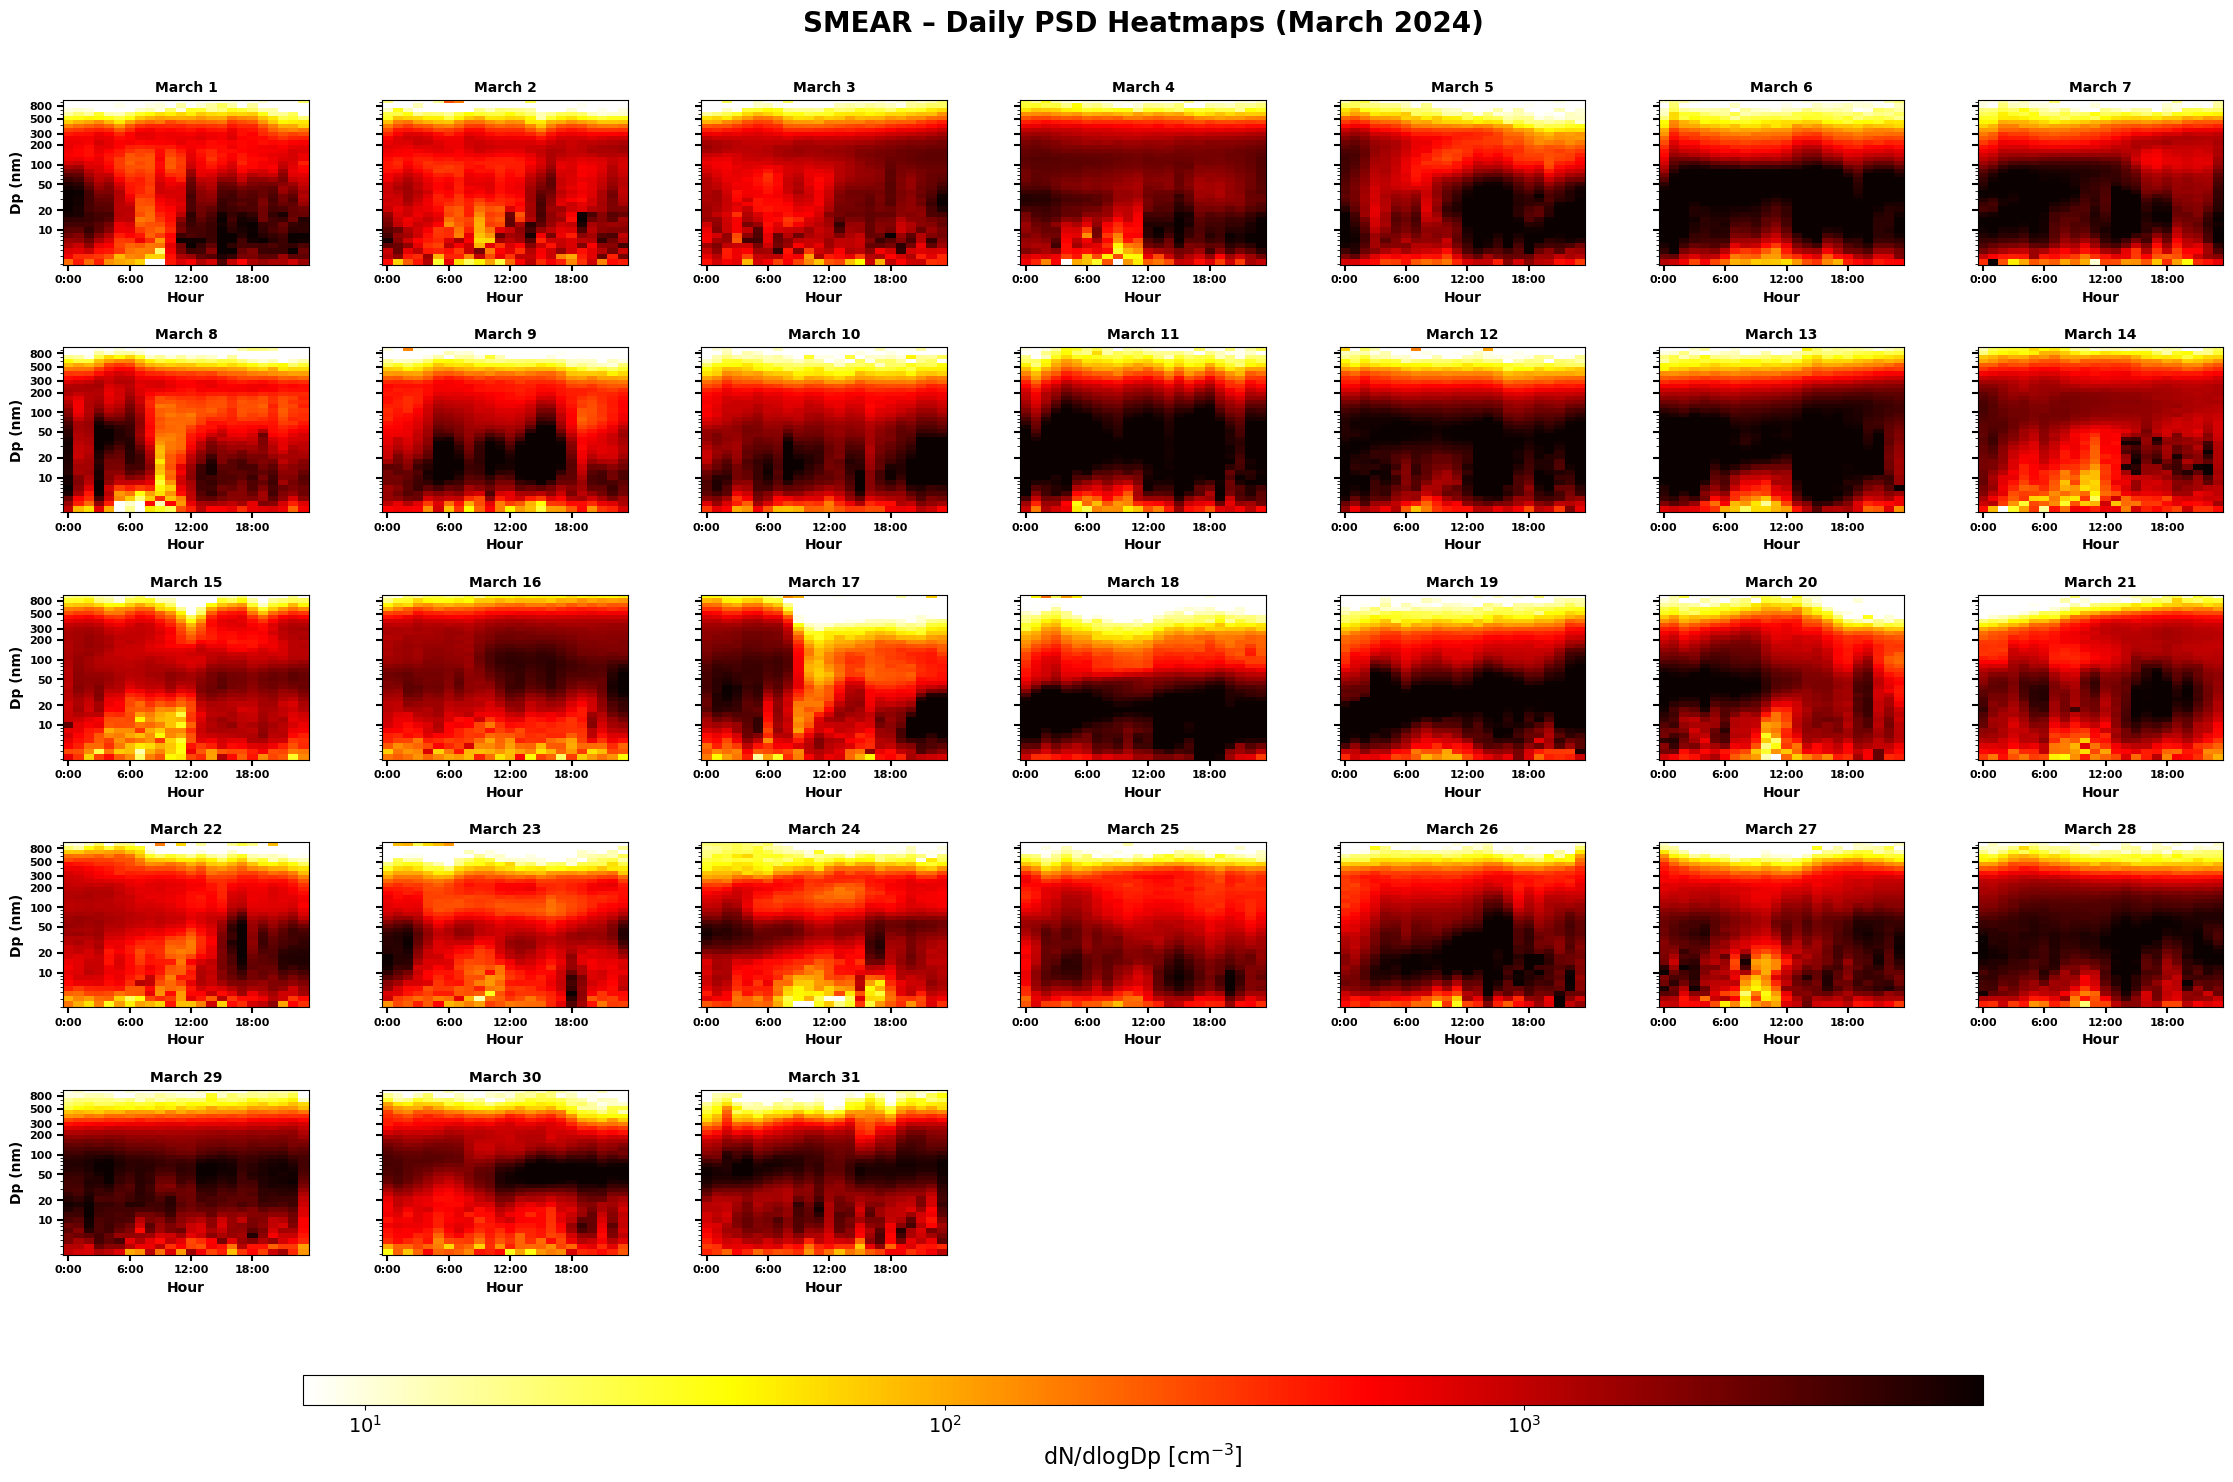

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# === Step 1: Load Excel Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_raw = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_raw = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Step 2: Filter March Data ===
tzs_march = tzs_raw[tzs_raw.index.month == 3].replace(0, np.nan)
smear_march = smear_raw[smear_raw.index.month == 3].replace(0, np.nan)

# === Step 3: Bin Midpoints ===
def process_bins(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    return bin_edges_nm, bin_midpoints

tzs_bins_nm, tzs_midpoints = process_bins(tzs_march)
smear_bins_nm, smear_midpoints = process_bins(smear_march)

# === Step 4: Preprocess (drop first bin, log-transform, set columns to midpoints) ===
def log_transform(data, bin_edges_nm, bin_midpoints):
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints
    return log_data

tzs_log = log_transform(tzs_march, tzs_bins_nm, tzs_midpoints)
smear_log = log_transform(smear_march, smear_bins_nm, smear_midpoints)

# === Step 5: Shared Color Scale ===
combined_values = np.concatenate([tzs_log.values.flatten(), smear_log.values.flatten()])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.get_cmap('hot_r')

# === Step 6: Y-axis Tick Settings ===
custom_ticks = [3, 10, 20, 50, 100, 200, 300, 500, 800, 1000]
valid_ticks = sorted(set([10, 800] + [t for t in custom_ticks if min(tzs_midpoints.min(), smear_midpoints.min()) <= t <= max(tzs_midpoints.max(), smear_midpoints.max())]))

# === Step 7: Plotting Function ===
def plot_daily_march_heatmaps(log_data, bin_midpoints, site_name, ytick_values, vmin, vmax):
    days = sorted(log_data.index.day.unique())
    cols = 7
    rows = math.ceil(len(days) / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 15), sharex=True, sharey=True)
    axes = axes.flatten()
    pcm = None

    for i, day in enumerate(days):
        ax = axes[i]
        day_data = log_data[log_data.index.day == day]
        hourly_avg = day_data.groupby(day_data.index.hour).mean()
        hourly_avg = hourly_avg.reindex(range(24))  # Ensure 24 hours

        X, Y = np.meshgrid(range(24), bin_midpoints)
        pcm = ax.pcolormesh(X, Y, hourly_avg.T, cmap=cmap, norm=norm, shading='auto')
        ax.set_yscale('log')

        ax.set_title(f"March {day}", fontweight='bold', fontsize=10)
        ax.set_yticks(ytick_values)
        ax.set_yticklabels([str(int(t)) for t in ytick_values], fontweight='bold', fontsize=8)
        ax.set_xticks(range(0, 24, 6))
        ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 6)], fontweight='bold', fontsize=8)

        ax.tick_params(axis='x', which='both', labelbottom=True)
        ax.tick_params(direction='out', length=4, width=1.5, labelsize=8)
        ax.set_xlabel("Hour", fontsize=10, fontweight='bold')
        if i % cols == 0:
            ax.set_ylabel("Dp (nm)", fontsize=10, fontweight='bold')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Colorbar
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    colorbar_ticks = np.arange(np.floor(vmin), np.ceil(vmax) + 1)
    colorbar_tick_labels = [f"$10^{{{int(t)}}}$" for t in colorbar_ticks]
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=colorbar_ticks)
    cbar.set_ticklabels(colorbar_tick_labels)
    cbar.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=16, weight='bold')
    cbar.ax.tick_params(labelsize=14)
    for label in cbar.ax.get_xticklabels():
        label.set_fontweight('bold')

    fig.suptitle(f"{site_name} – Daily PSD Heatmaps (March 2024)", fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.15, wspace=0.3, hspace=0.5)
    plt.show()

# === Step 8: Plot TZS (Page 1) ===
plot_daily_march_heatmaps(tzs_log, tzs_midpoints, "TZS", valid_ticks, vmin, vmax)

# === Step 9: Plot SMEAR (Page 2) ===
plot_daily_march_heatmaps(smear_log, smear_midpoints, "SMEAR", valid_ticks, vmin, vmax)

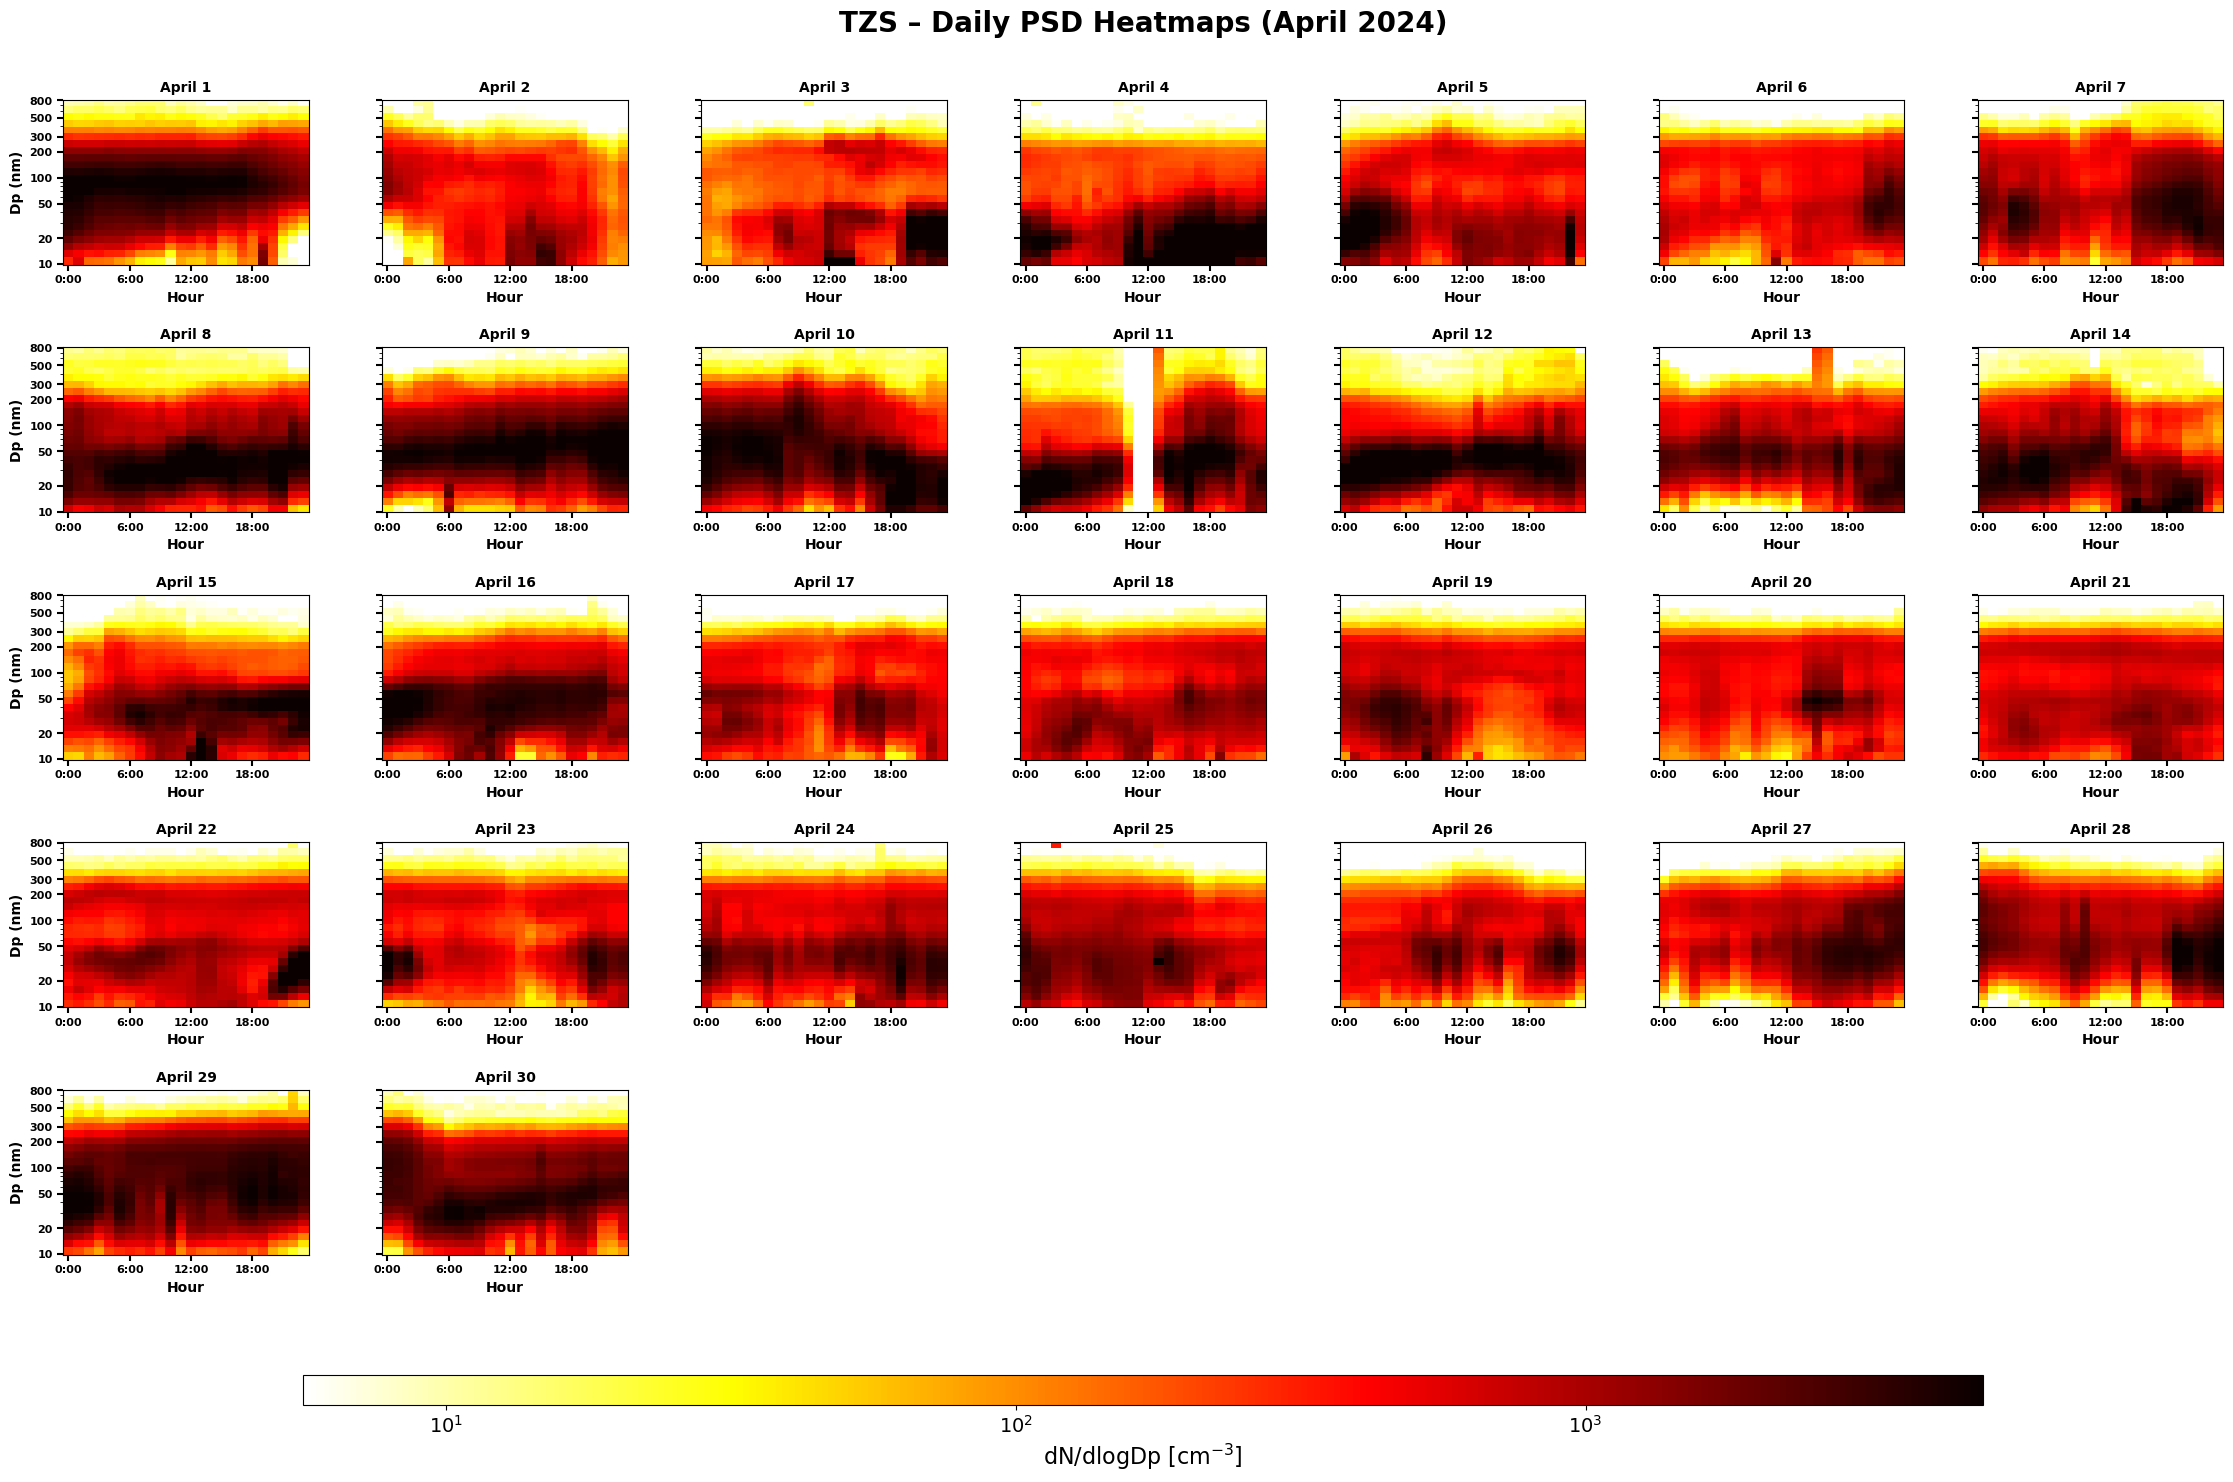

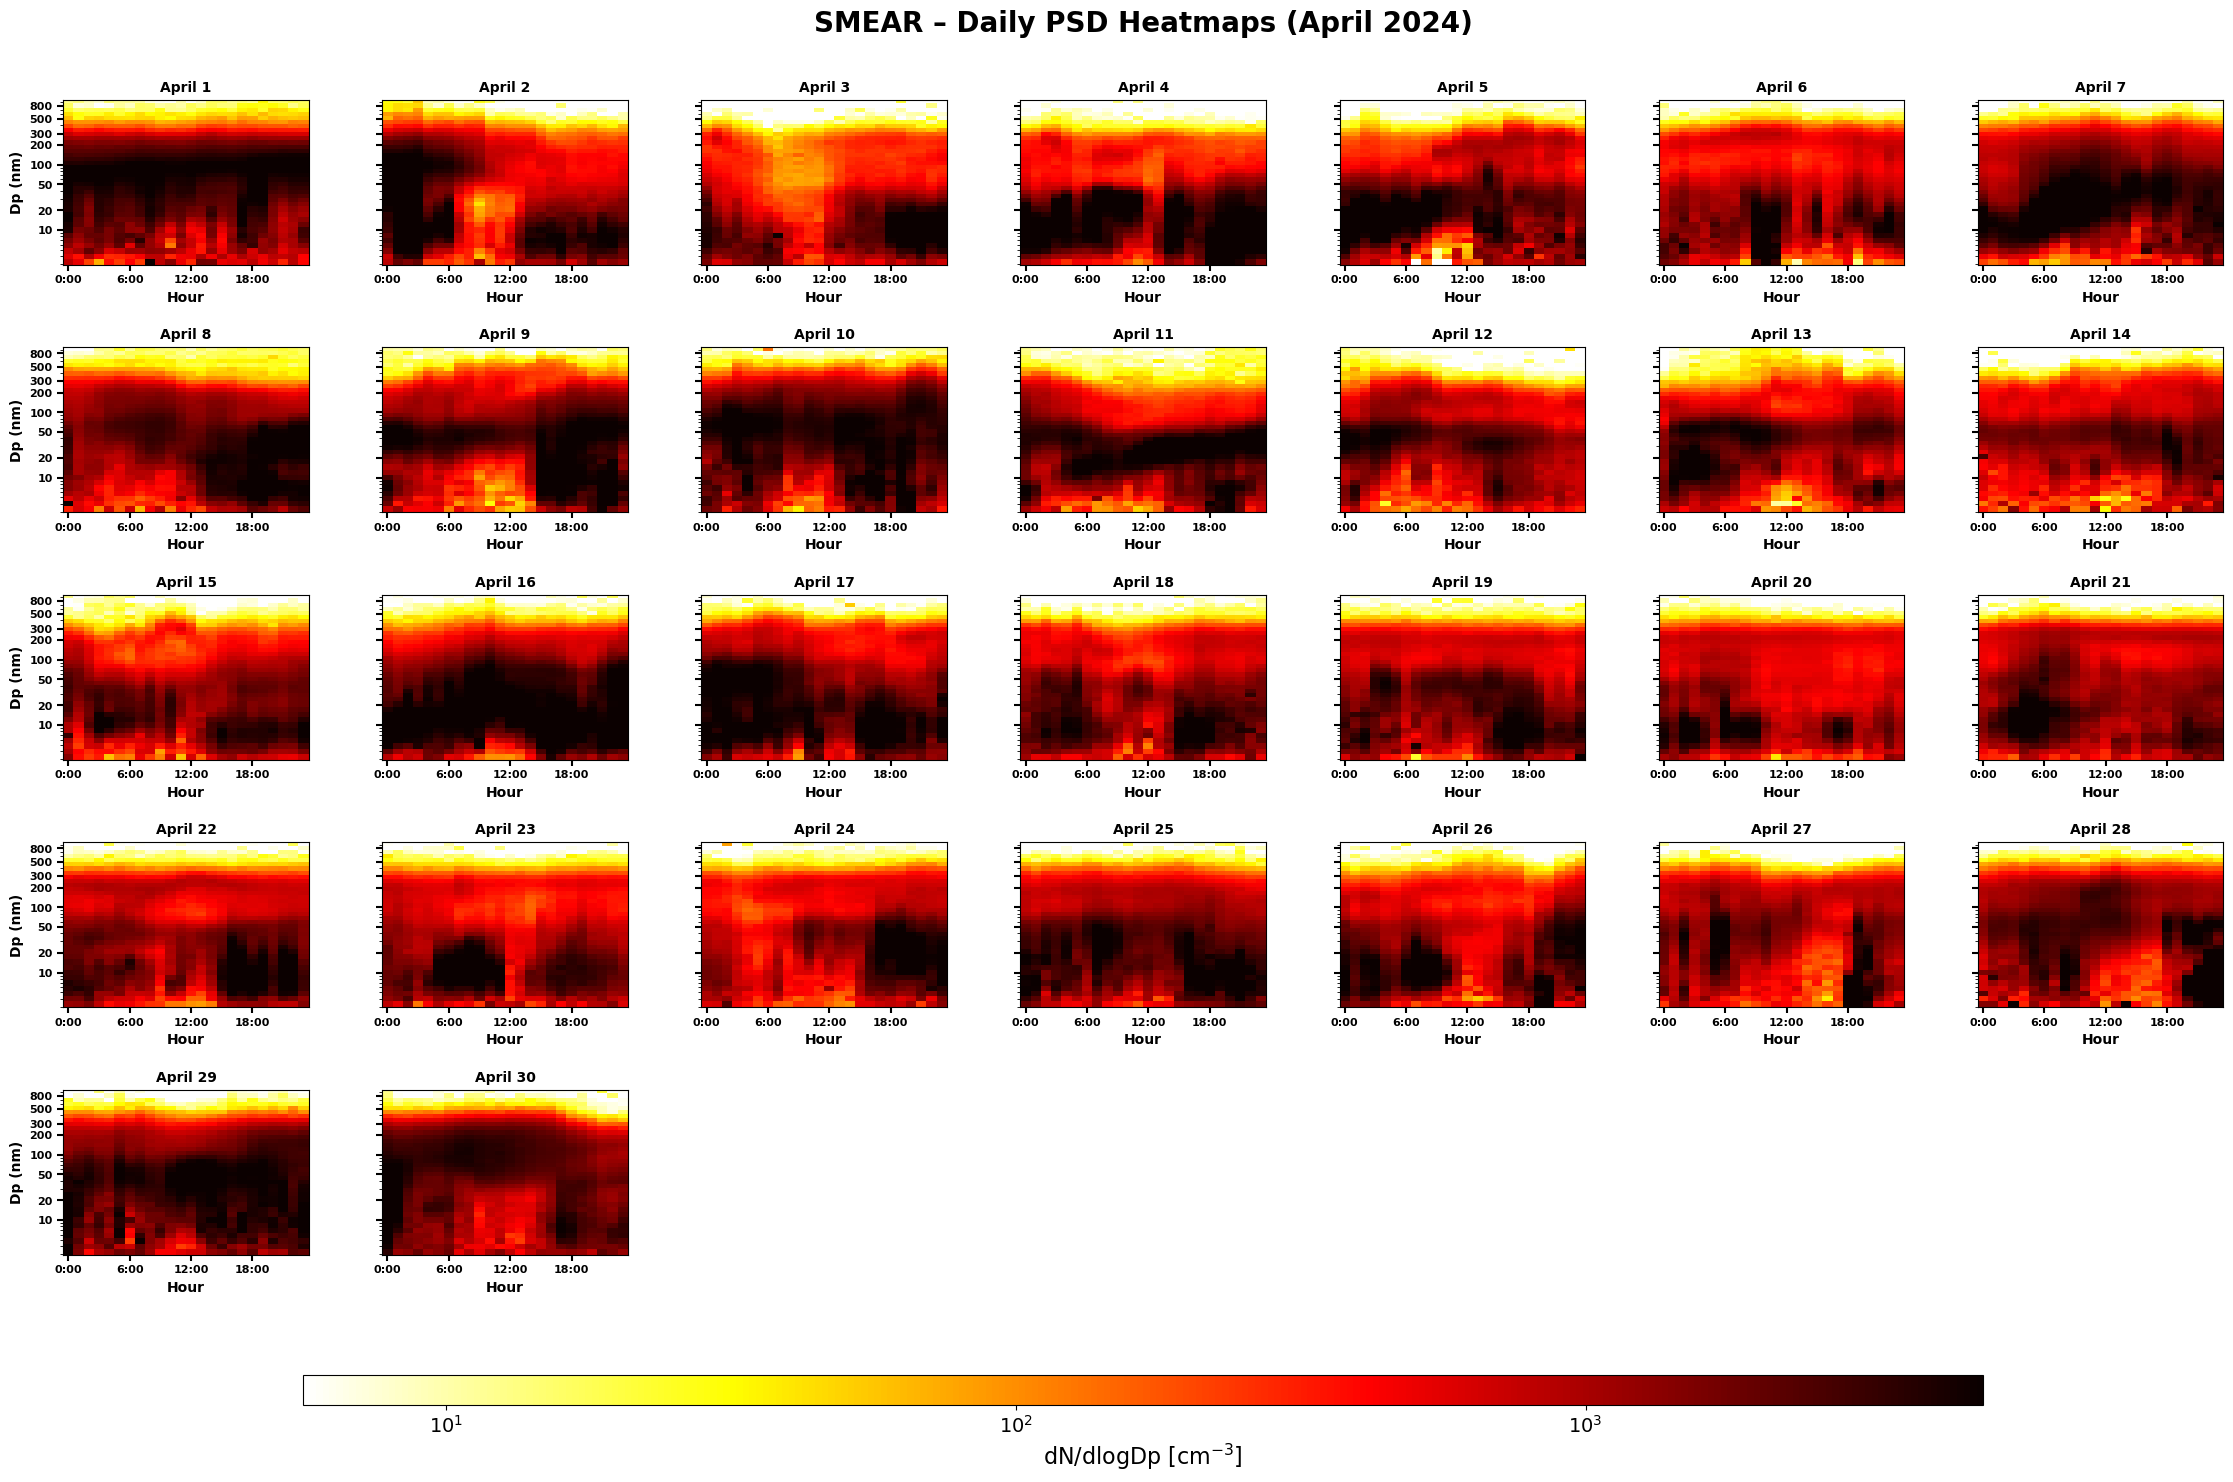

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# === Step 1: Load Excel Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_raw = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_raw = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Step 2: Filter April Data ===
tzs_april = tzs_raw[tzs_raw.index.month == 4].replace(0, np.nan)
smear_april = smear_raw[smear_raw.index.month == 4].replace(0, np.nan)

# === Step 3: Bin Midpoints ===
def process_bins(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    return bin_edges_nm, bin_midpoints

tzs_bins_nm, tzs_midpoints = process_bins(tzs_april)
smear_bins_nm, smear_midpoints = process_bins(smear_april)

# === Step 4: Preprocess (drop first bin, log-transform, set columns to midpoints) ===
def log_transform(data, bin_edges_nm, bin_midpoints):
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints
    return log_data

tzs_log = log_transform(tzs_april, tzs_bins_nm, tzs_midpoints)
smear_log = log_transform(smear_april, smear_bins_nm, smear_midpoints)

# === Step 5: Shared Color Scale ===
combined_values = np.concatenate([tzs_log.values.flatten(), smear_log.values.flatten()])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.get_cmap('hot_r')

# === Step 6: Y-axis Tick Settings ===
custom_ticks = [3, 10, 20, 50, 100, 200, 300, 500, 800, 1000]
valid_ticks = sorted(set([10, 800] + [t for t in custom_ticks if min(tzs_midpoints.min(), smear_midpoints.min()) <= t <= max(tzs_midpoints.max(), smear_midpoints.max())]))

# === Step 7: Plotting Function ===
def plot_daily_april_heatmaps(log_data, bin_midpoints, site_name, ytick_values, vmin, vmax):
    days = sorted(log_data.index.day.unique())
    cols = 7
    rows = math.ceil(len(days) / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 15), sharex=True, sharey=True)
    axes = axes.flatten()
    pcm = None

    for i, day in enumerate(days):
        ax = axes[i]
        day_data = log_data[log_data.index.day == day]
        hourly_avg = day_data.groupby(day_data.index.hour).mean()
        hourly_avg = hourly_avg.reindex(range(24))  # Ensure 24 hours

        X, Y = np.meshgrid(range(24), bin_midpoints)
        pcm = ax.pcolormesh(X, Y, hourly_avg.T, cmap=cmap, norm=norm, shading='auto')
        ax.set_yscale('log')

        ax.set_title(f"April {day}", fontweight='bold', fontsize=10)
        ax.set_yticks(ytick_values)
        ax.set_yticklabels([str(int(t)) for t in ytick_values], fontweight='bold', fontsize=8)
        ax.set_xticks(range(0, 24, 6))
        ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 6)], fontweight='bold', fontsize=8)

        ax.tick_params(axis='x', which='both', labelbottom=True)
        ax.tick_params(direction='out', length=4, width=1.5, labelsize=8)
        ax.set_xlabel("Hour", fontsize=10, fontweight='bold')
        if i % cols == 0:
            ax.set_ylabel("Dp (nm)", fontsize=10, fontweight='bold')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Colorbar
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    colorbar_ticks = np.arange(np.floor(vmin), np.ceil(vmax) + 1)
    colorbar_tick_labels = [f"$10^{{{int(t)}}}$" for t in colorbar_ticks]
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=colorbar_ticks)
    cbar.set_ticklabels(colorbar_tick_labels)
    cbar.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=16, weight='bold')
    cbar.ax.tick_params(labelsize=14)
    for label in cbar.ax.get_xticklabels():
        label.set_fontweight('bold')

    fig.suptitle(f"{site_name} – Daily PSD Heatmaps (April 2024)", fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.15, wspace=0.3, hspace=0.5)
    plt.show()

# === Step 8: Plot TZS (Page 1) ===
plot_daily_april_heatmaps(tzs_log, tzs_midpoints, "TZS", valid_ticks, vmin, vmax)

# === Step 9: Plot SMEAR (Page 2) ===
plot_daily_april_heatmaps(smear_log, smear_midpoints, "SMEAR", valid_ticks, vmin, vmax)


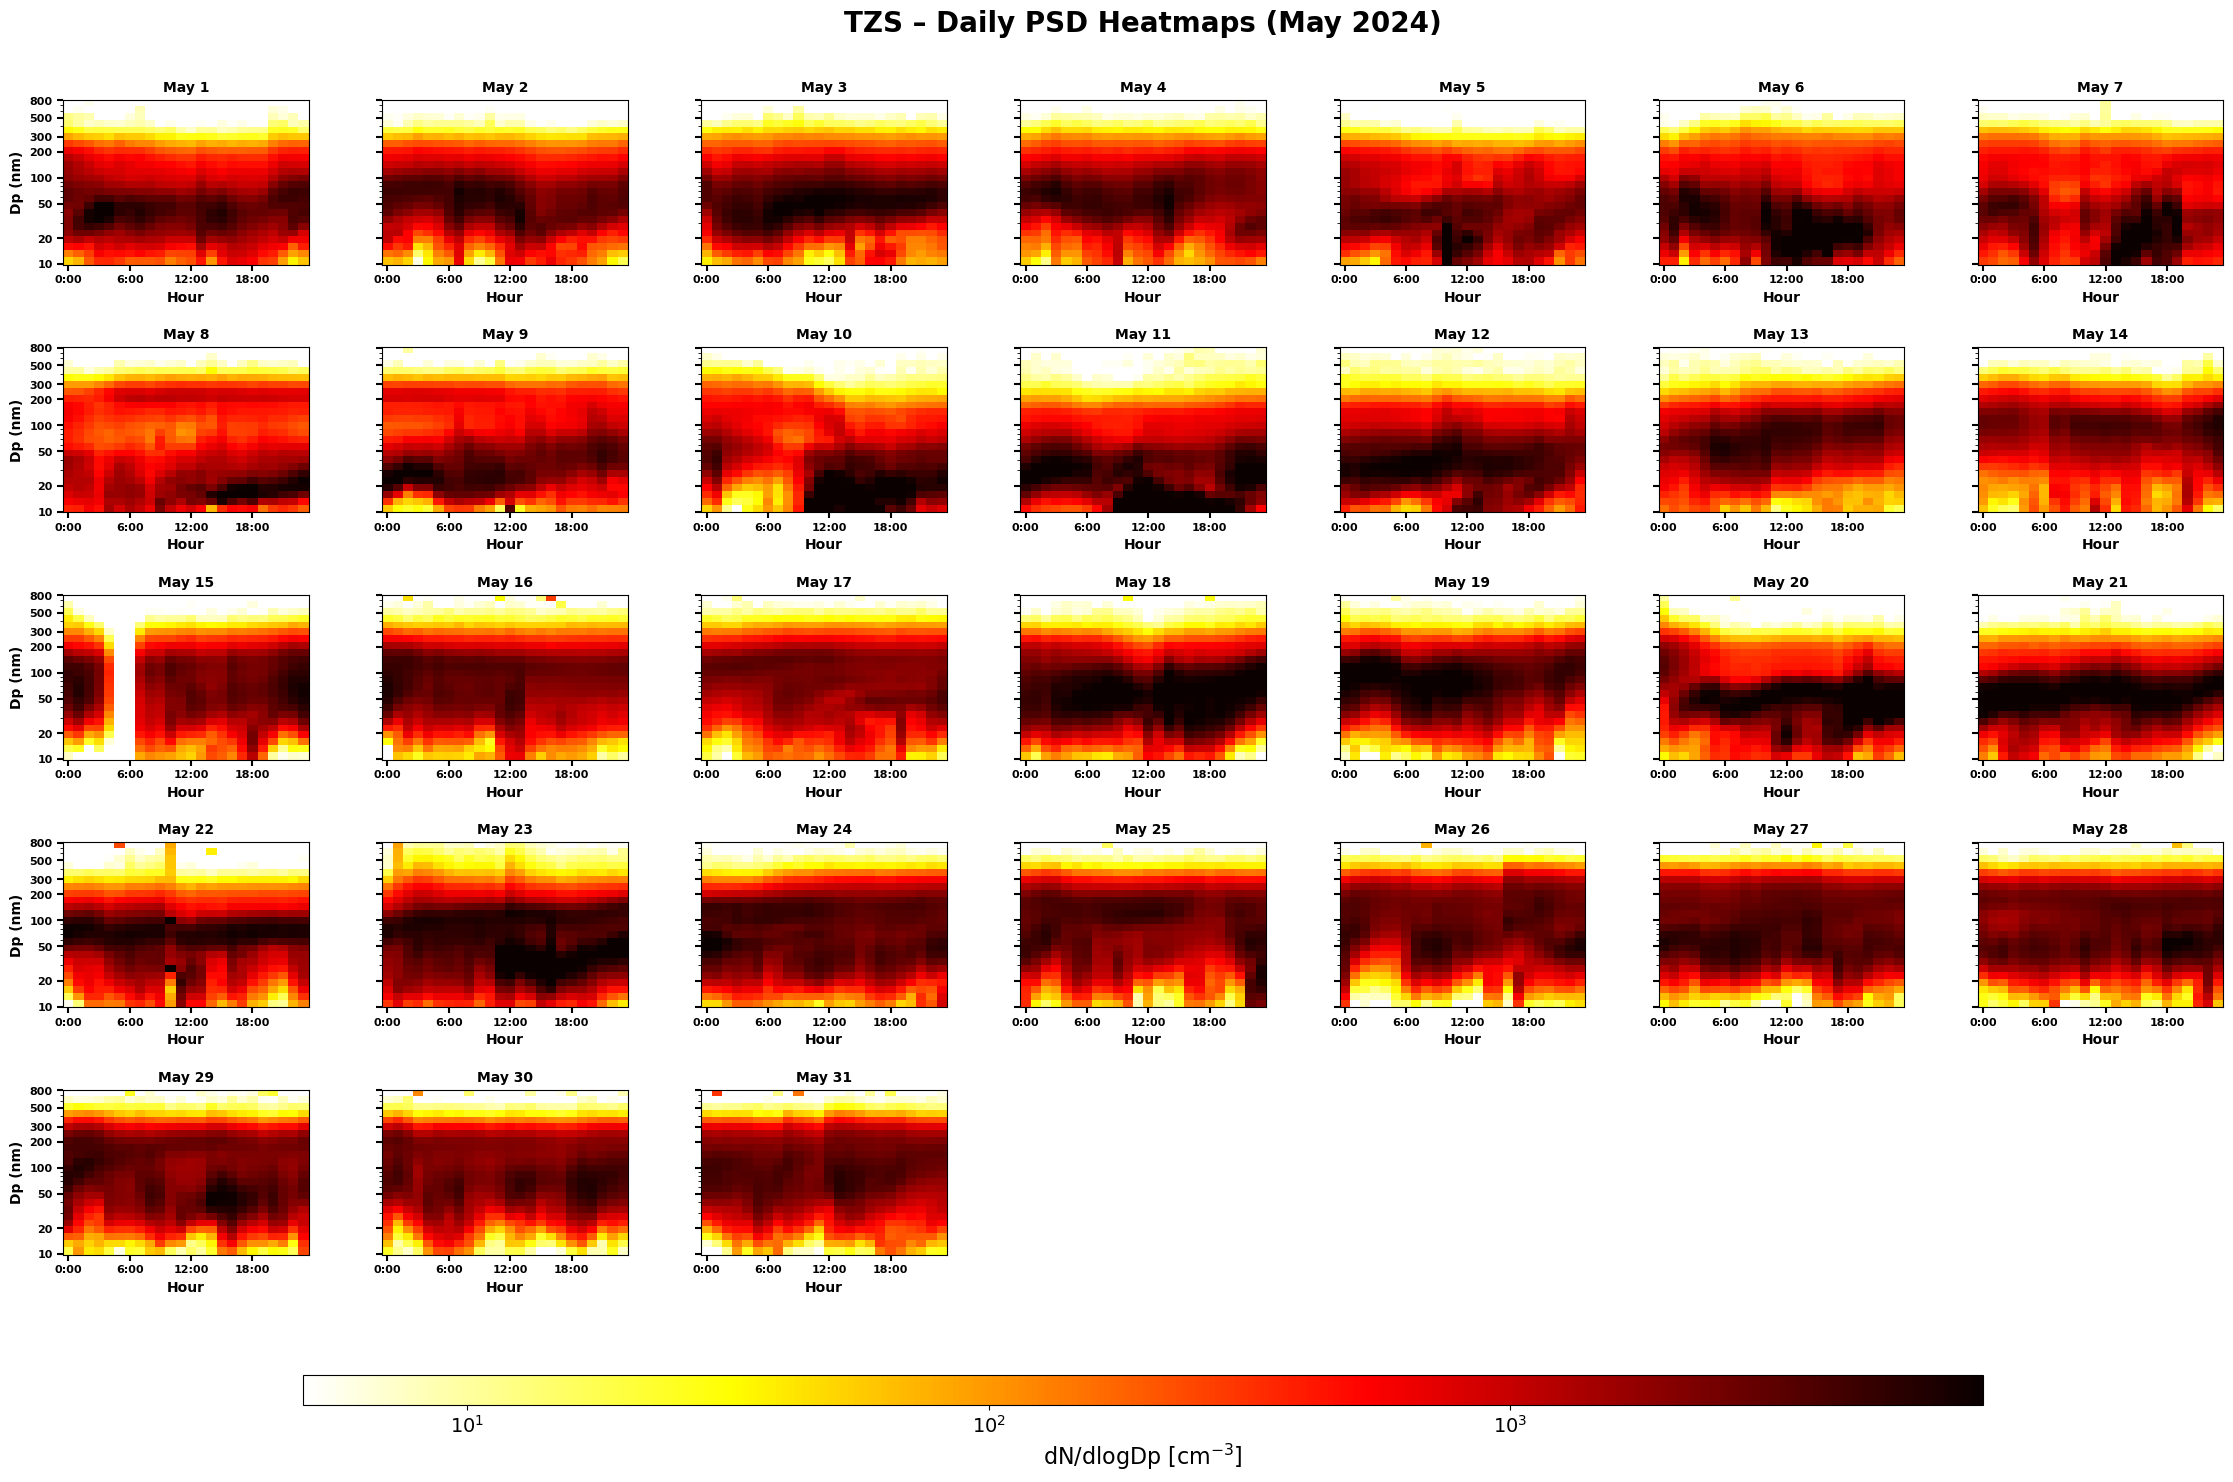

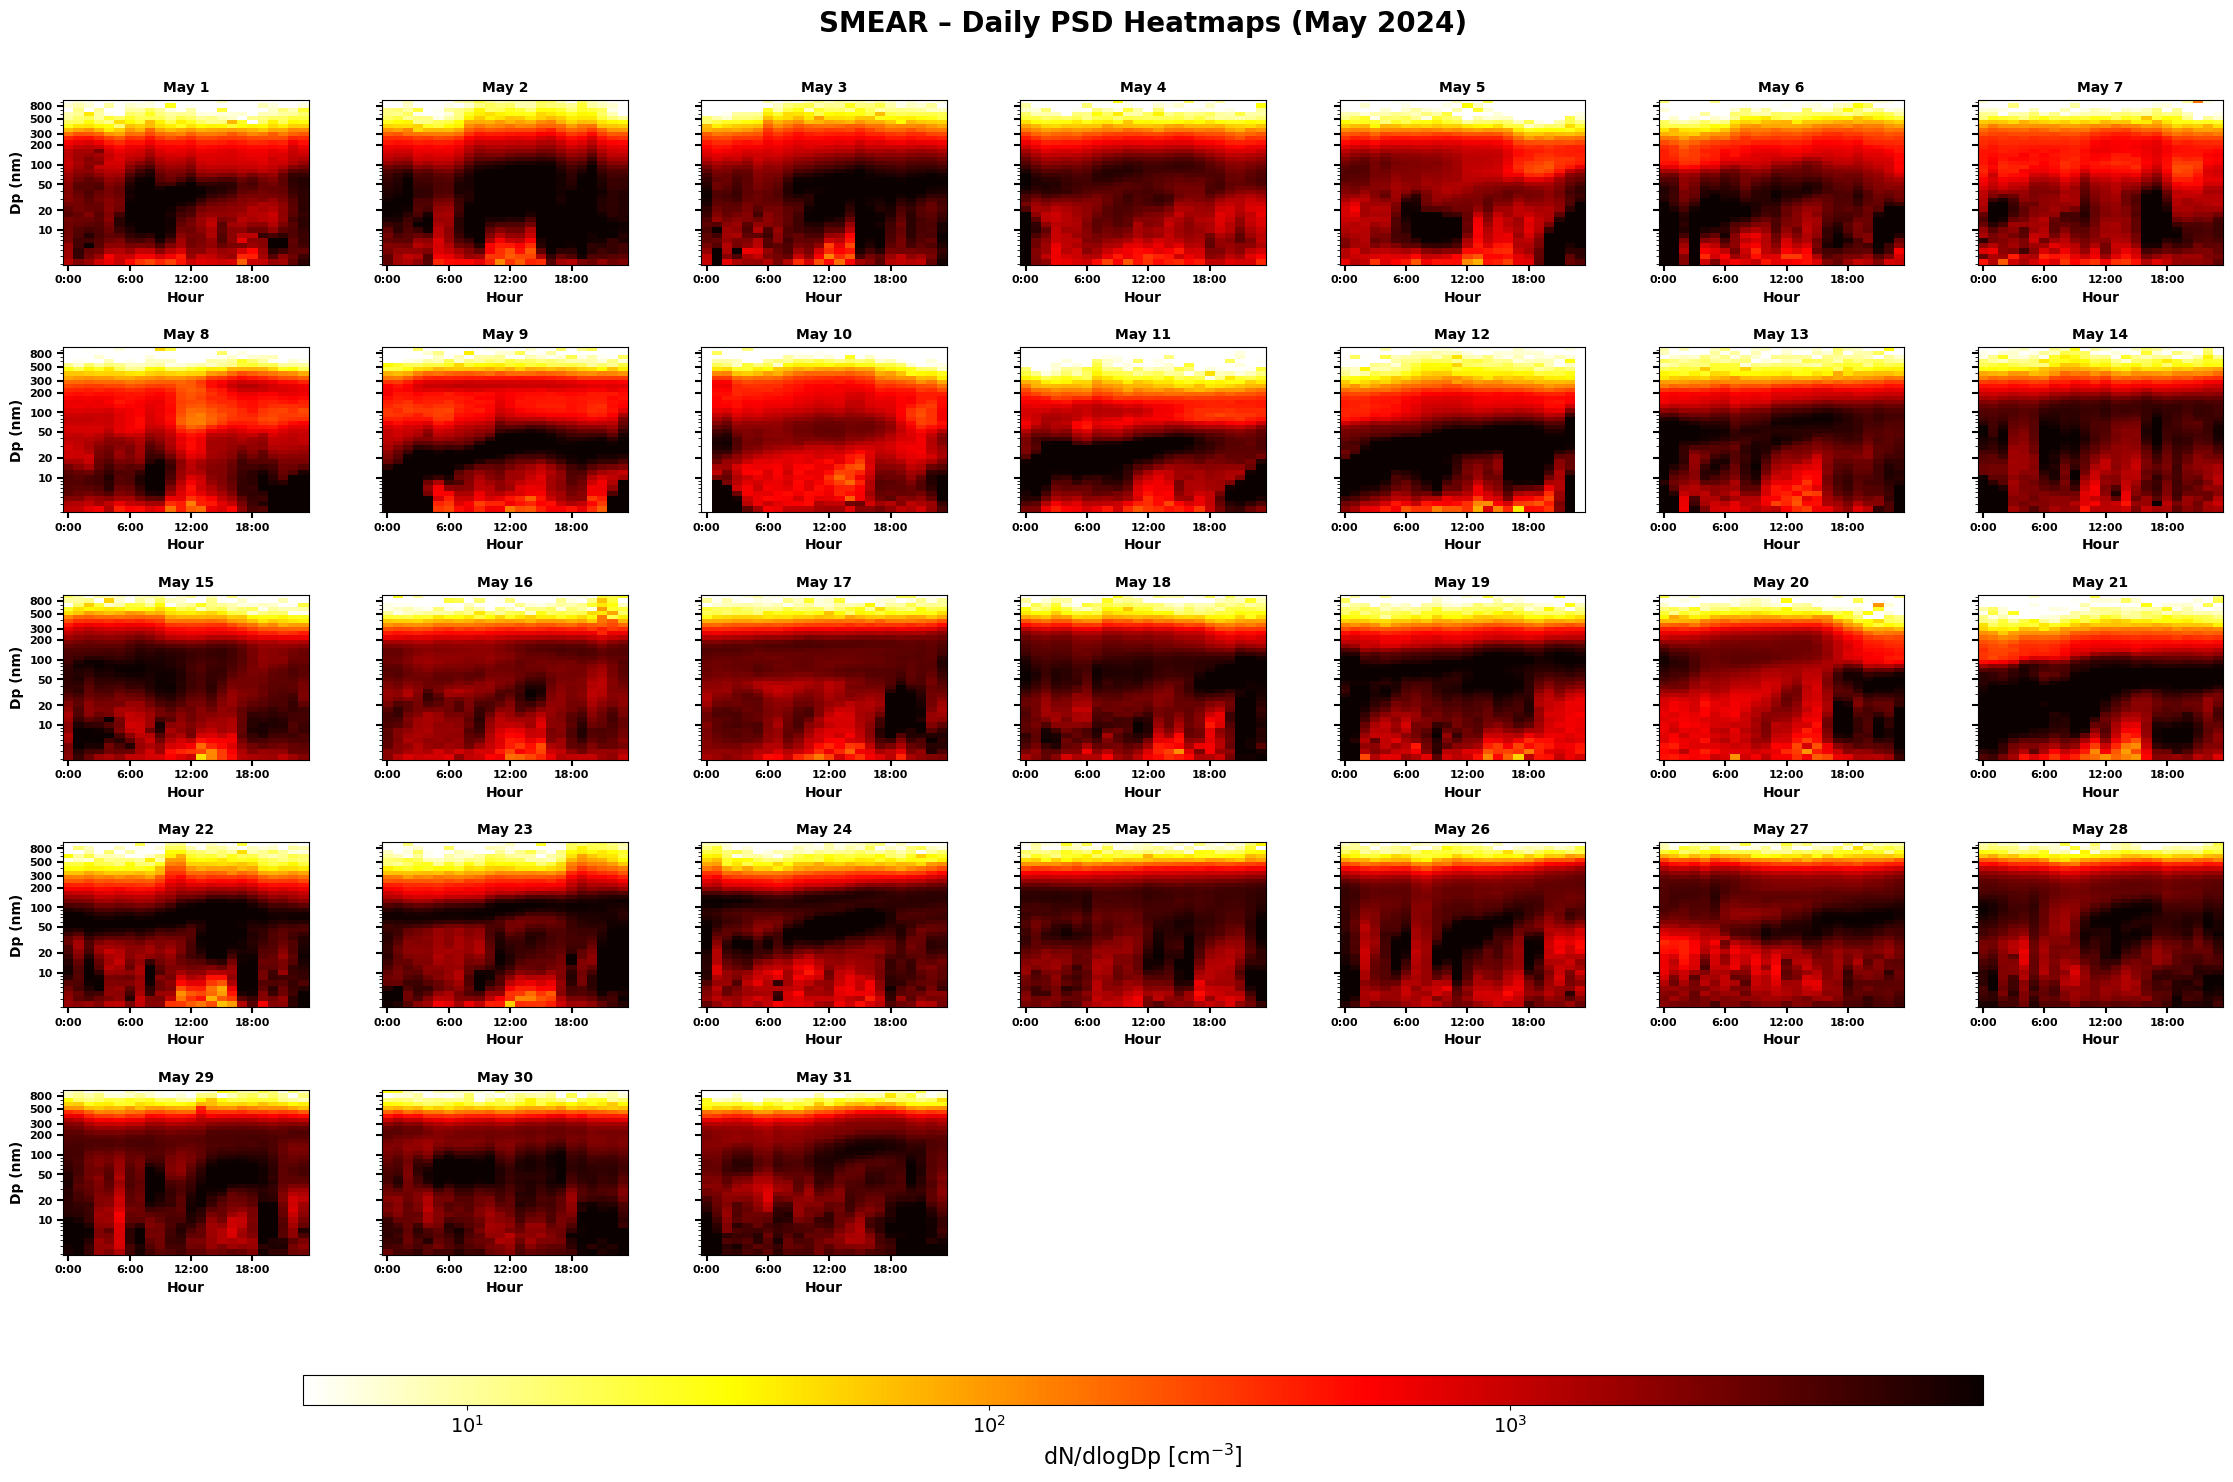

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# === Step 1: Load Excel Data ===
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'
tzs_raw = pd.read_excel(file_path, sheet_name='TZS', index_col='Date', parse_dates=True)
smear_raw = pd.read_excel(file_path, sheet_name='SMEAR', index_col='Date', parse_dates=True)

# === Step 2: Filter May Data ===
tzs_may = tzs_raw[tzs_raw.index.month == 5].replace(0, np.nan)
smear_may = smear_raw[smear_raw.index.month == 5].replace(0, np.nan)

# === Step 3: Bin Midpoints ===
def process_bins(data):
    bin_edges_m = data.columns.astype(float).to_numpy()
    bin_edges_nm = bin_edges_m * 1e9
    bin_midpoints = np.sqrt(bin_edges_nm[:-1] * bin_edges_nm[1:])
    return bin_edges_nm, bin_midpoints

tzs_bins_nm, tzs_midpoints = process_bins(tzs_may)
smear_bins_nm, smear_midpoints = process_bins(smear_may)

# === Step 4: Preprocess (drop first bin, log-transform, set columns to midpoints) ===
def log_transform(data, bin_edges_nm, bin_midpoints):
    data.columns = bin_edges_nm
    trimmed = data.iloc[:, 1:]
    log_data = np.log10(trimmed)
    log_data.columns = bin_midpoints
    return log_data

tzs_log = log_transform(tzs_may, tzs_bins_nm, tzs_midpoints)
smear_log = log_transform(smear_may, smear_bins_nm, smear_midpoints)

# === Step 5: Shared Color Scale ===
combined_values = np.concatenate([tzs_log.values.flatten(), smear_log.values.flatten()])
vmin = np.nanpercentile(combined_values, 5)
vmax = np.nanpercentile(combined_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.get_cmap('hot_r')

# === Step 6: Y-axis Tick Settings ===
custom_ticks = [3, 10, 20, 50, 100, 200, 300, 500, 800, 1000]
valid_ticks = sorted(set([10, 800] + [t for t in custom_ticks if min(tzs_midpoints.min(), smear_midpoints.min()) <= t <= max(tzs_midpoints.max(), smear_midpoints.max())]))

# === Step 7: Plotting Function ===
def plot_daily_may_heatmaps(log_data, bin_midpoints, site_name, ytick_values, vmin, vmax):
    days = sorted(log_data.index.day.unique())
    cols = 7
    rows = math.ceil(len(days) / cols)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 15), sharex=True, sharey=True)
    axes = axes.flatten()
    pcm = None

    for i, day in enumerate(days):
        ax = axes[i]
        day_data = log_data[log_data.index.day == day]
        hourly_avg = day_data.groupby(day_data.index.hour).mean()
        hourly_avg = hourly_avg.reindex(range(24))  # Ensure 24 hours

        X, Y = np.meshgrid(range(24), bin_midpoints)
        pcm = ax.pcolormesh(X, Y, hourly_avg.T, cmap=cmap, norm=norm, shading='auto')
        ax.set_yscale('log')

        ax.set_title(f"May {day}", fontweight='bold', fontsize=10)
        ax.set_yticks(ytick_values)
        ax.set_yticklabels([str(int(t)) for t in ytick_values], fontweight='bold', fontsize=8)
        ax.set_xticks(range(0, 24, 6))
        ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 6)], fontweight='bold', fontsize=8)

        ax.tick_params(axis='x', which='both', labelbottom=True)
        ax.tick_params(direction='out', length=4, width=1.5, labelsize=8)
        ax.set_xlabel("Hour", fontsize=10, fontweight='bold')
        if i % cols == 0:
            ax.set_ylabel("Dp (nm)", fontsize=10, fontweight='bold')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Colorbar
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    colorbar_ticks = np.arange(np.floor(vmin), np.ceil(vmax) + 1)
    colorbar_tick_labels = [f"$10^{{{int(t)}}}$" for t in colorbar_ticks]
    cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=colorbar_ticks)
    cbar.set_ticklabels(colorbar_tick_labels)
    cbar.set_label(r'$\mathrm{dN/dlogDp}\ [\mathrm{cm}^{-3}]$', fontsize=16, weight='bold')
    cbar.ax.tick_params(labelsize=14)
    for label in cbar.ax.get_xticklabels():
        label.set_fontweight('bold')

    fig.suptitle(f"{site_name} – Daily PSD Heatmaps (May 2024)", fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.15, wspace=0.3, hspace=0.5)
    plt.show()

# === Step 8: Plot TZS (Page 1) ===
plot_daily_may_heatmaps(tzs_log, tzs_midpoints, "TZS", valid_ticks, vmin, vmax)

# === Step 9: Plot SMEAR (Page 2) ===
plot_daily_may_heatmaps(smear_log, smear_midpoints, "SMEAR", valid_ticks, vmin, vmax)